<a href="https://colab.research.google.com/github/Jflorez05/Monografia_Especializacion/blob/main/Monografia_Pred_Consumo_Gas_Resumen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Parte 1. Lectura de datos crudos.
**Libreria de XM para datos del mercado eléctrico**

In [1]:
# Instalación de libreria XM y librerias necesarias de modelos.
!pip install pydataxm
!pip install skforecast
!pip install pmdarima

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 5.7 MB/s eta 0:00:00
  Created wheel for pydataxm: filename=pydataxm-0.3.10-py3-none-any.whl size=9415 sha256=bf0fffed054bb7d3abd8d9ba8855b7f1620cf082e013b8438f86101cc9b920b0
  Stored in directory: /root/.cache/pip/wheels/05/1b/e9/4ad909f27922b736a6fbce6282c0f3fbdf311245b500f62989
Successfully built pydataxm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.8 MB/s eta 0:00:00


In [2]:
# Libreria lectura de datos XM
from pydataxm import *

#Librerias básicas manejo de datos
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns

#Librerias visualización
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Librerias análisis exploratorio
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

# Librerias preparación de datos para Modelos de redes neuronales.
import tensorflow as tf
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU



Lectura desde API XM (Administrador del mercado mayorista de energía en Colombia). Base de datos con colecciones y variables del mercado mayorista de energía, en la que converge información relacionada con la demanda energética diaria del país, las diversas fuentes de generación electrica que componen la matriz energética colombiana, despacho térmico para la generación de energía electrica a partir diferentes tipos de combustible, variables históricas de precios, agentes generadores, entre otros.



### Lectura de datos crudos desde la base de datos de XM de consumo de combustible de los agentes del sistema en MBTU
**Descripción de las variables:**
1.  Id: indicador de recurso
2. Values_Name: Tipo de combustible utilizado para la generación
3. Values_code: Nombre codificado de la central térmica.
4. Values_Hour0"n": Cantidad de energía consumida en MBTU en la hora "n" por el agente termico en un día particular.
5. Date: Día de consumo.

#### **Correlación entre el comsumo de combustible y los aportes hídricos del sistema**

### **Análisis de correlación con el precio en bolsa Nacional**

In [3]:
# tipos de datos df
df_consumos_precios = pd.read_csv('df_consumos_precios.csv')
df_consumos_precios.info()

# Convertir columna Date en tipo datetime
df_consumos_precios['Date'] = pd.to_datetime(df_consumos_precios['Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2556 non-null   object 
 1   MBTU_daily       2556 non-null   float64
 2   mes              2556 non-null   int64  
 3   dia_semana       2556 non-null   int64  
 4   fin_de_semana    2556 non-null   int64  
 5   Precios_diarios  2556 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 119.9+ KB


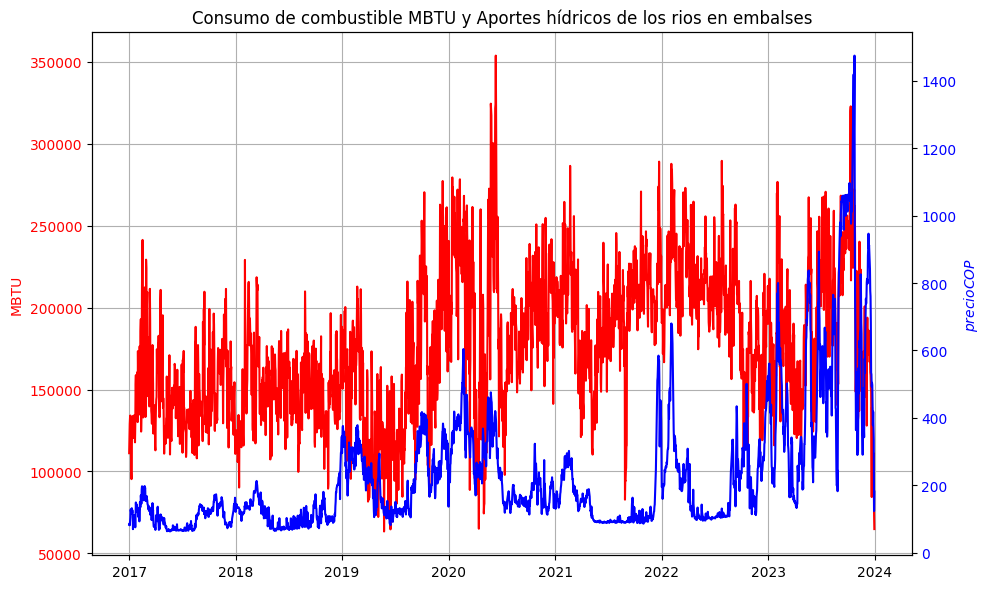

In [4]:
# Lectura de archivo csv con los datos consolidados.
df_consumos_precios = pd.read_csv('df_consumos_precios.csv')

fecha_inicio = dt.datetime.strptime("2017-1-1", "%Y-%m-%d")
fecha_fin = dt.datetime.strptime("2023-12-31", "%Y-%m-%d")
df_consumos_precios['Date'] = pd.to_datetime(df_consumos_precios['Date'])

# Filtrado de datos en inicio y fin
df_rango = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio) & (df_consumos_precios['Date'] <= fecha_fin)]

# Crear la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la primera serie en el primer eje
ax1.plot(df_rango['Date'], df_rango['MBTU_daily'], color='r', label='Consumo de combustible MBTU')
ax1.set_ylabel('MBTU', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True)

# Crear un segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# Graficar la segunda serie en el segundo eje (por ejemplo, 'OtherValue')
ax2.plot(df_rango['Date'], df_rango['Precios_diarios'], color='b', label='Precio en bolsa')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('$precio COP$', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Título de la gráfica
plt.title('Consumo de combustible MBTU y Aportes hídricos de los rios en embalses')

# Mostrar la gráfica
fig.tight_layout()
plt.show()

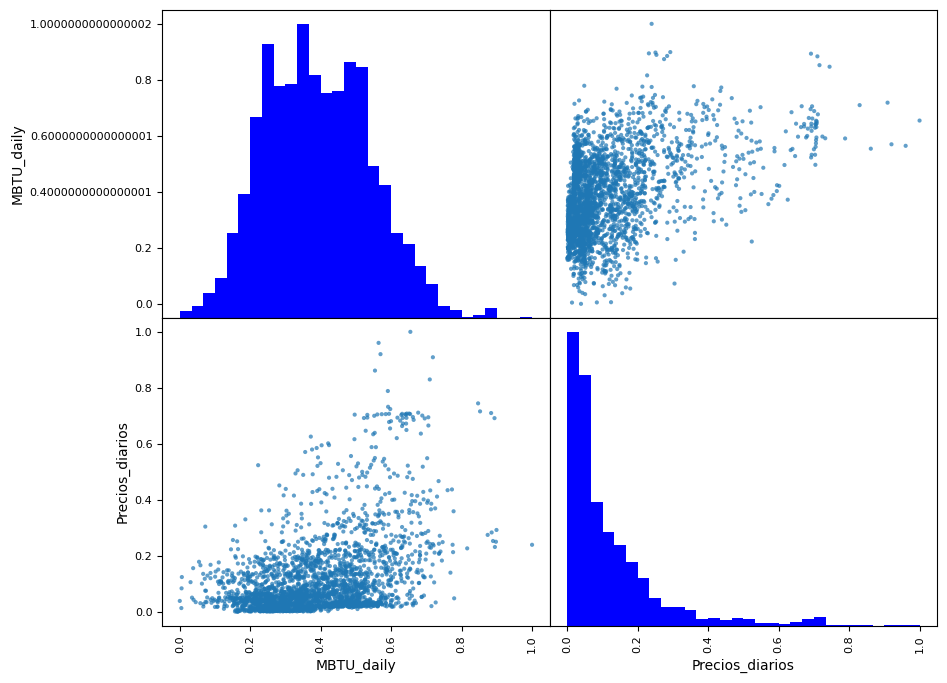

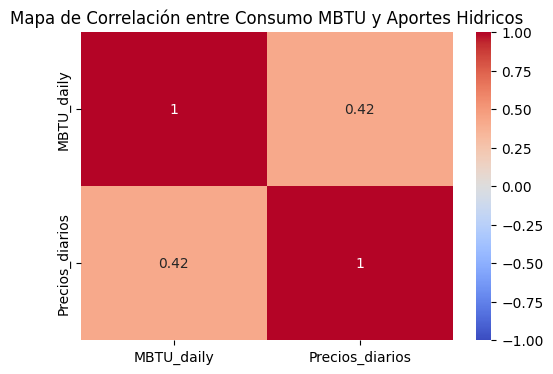

In [5]:
data_consumo_normalizada = df_consumos_precios[['MBTU_daily', 'Precios_diarios']]
data_consumo_normalizada = (data_consumo_normalizada - data_consumo_normalizada.min())/(data_consumo_normalizada.max() - data_consumo_normalizada.min())

pd.plotting.scatter_matrix(data_consumo_normalizada, alpha=0.7, figsize=(10, 8), range_padding = 0.1, diagonal='hist',
                            hist_kwds = {'bins':30, 'color':'blue'})
plt.show()

# Calcular la matriz de correlación
correlacion = data_consumo_normalizada.corr()

# Crear un mapa de calor para visualizar la correlación
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación entre Consumo MBTU y Aportes Hidricos')
plt.show()

### Parte 3. Creación de datasets para entrenamiento y prueba de los modelos predictivos.
- Se debe considerar si es necesario excluir del estudio una epoca

**Parte 4.** Análisis exploratorio de verificaciones en serie de tiempo.

- Se realiza análisis de estacionalidad, tendencia y error de los datos.
- Se reliza test de dicked fuller.
- El análisis y pruebas se realizan en base al dataframe "df_rango" en un rango particular de datos.

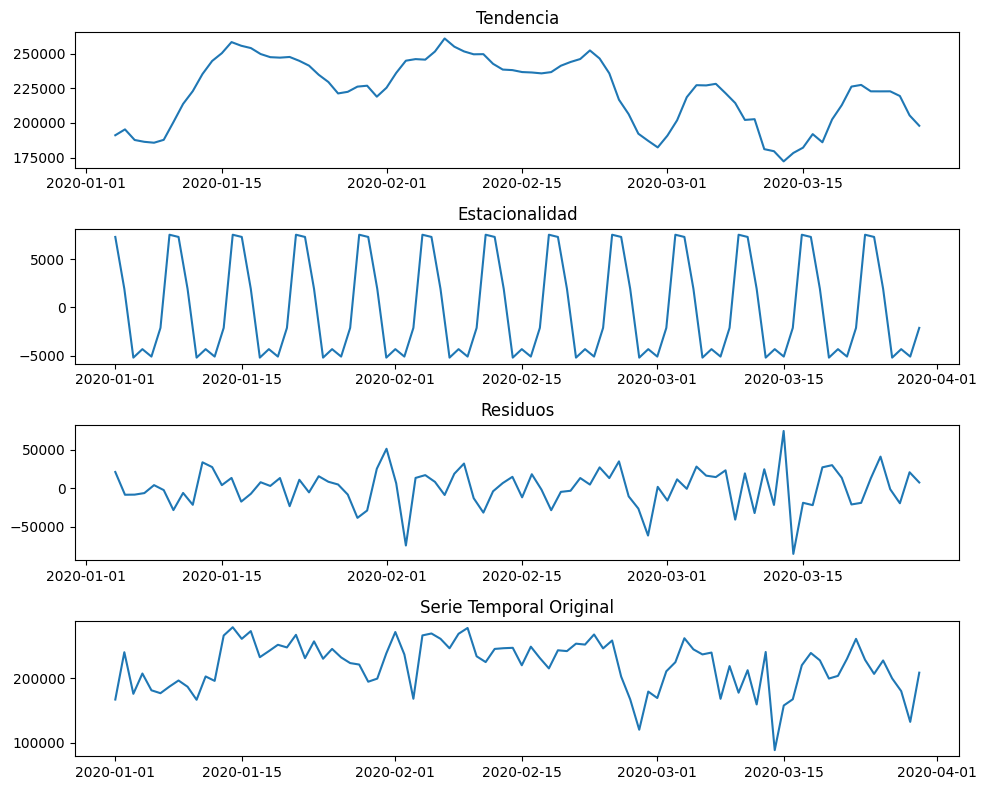

In [6]:
fecha_inicio_descom = dt.datetime.strptime("2020-1-1", "%Y-%m-%d")
fecha_fin_descom = dt.datetime.strptime("2020-3-30", "%Y-%m-%d")

# Filtrado de datos en inicio y fin
df_rango_descom = df_consumos_precios[(df_consumos_precios['Date'] >= fecha_inicio_descom) & (df_consumos_precios['Date'] <= fecha_fin_descom)]

# Descomposición de series temporales
df_rango_descom.set_index('Date', inplace=True)
decomposition = seasonal_decompose(df_rango_descom['MBTU_daily'], model='additive')
# Visualización de la descomposición
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Tendencia')

# Estacionalidad
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')

# Residuos
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residuos')

# Serie Temporal Original
plt.subplot(414)
plt.plot(df_rango_descom['MBTU_daily'])
plt.title('Serie Temporal Original')

plt.tight_layout()
plt.show()

**Análisis resultados**
Se puede notar en la descomposición de la serie temporal se tiene una tendencia variante en el tiempo sin un patro muy claro. Una parte estacional que tiene concordancia con los datos pero de la mano con residuos de esta descomposición que tienen un comportamiento variable en los diferentes años.

In [7]:
# Test de Dicked Fuller
# Test de estacionalidad
# Aplicar el test de Dickey-Fuller
result = sm.tsa.adfuller(df_rango['MBTU_daily'])

# Mostrar los resultados del test
print('Estadística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])

# Interpretación de los resultados
if result[1] <= 0.05:
    print("La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).")
else:
    print("La serie temporal no es estacionaria (no podemos rechazar la hipótesis nula de la presencia de una raíz unitaria).")

Estadística ADF: -4.210002537144275
Valor p: 0.0006336773791226513
Valores críticos: {'1%': -3.432939379929173, '5%': -2.862683979868293, '10%': -2.5673789838429837}
La serie temporal es estacionaria (rechazamos la hipótesis nula de la presencia de una raíz unitaria).


<Figure size 1200x600 with 0 Axes>

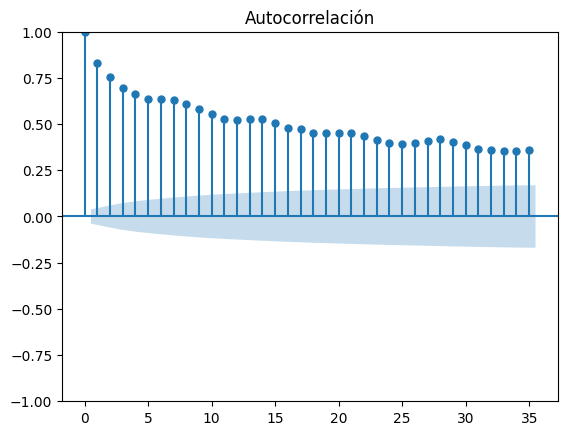

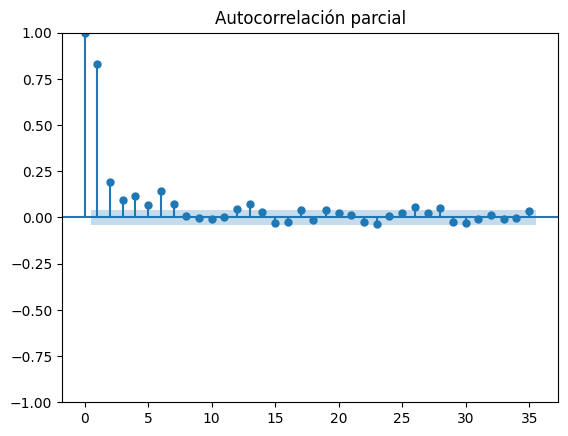

In [8]:
# Graficas ACF y PACF
plt.figure(figsize=(12, 6))

plot_acf(df_consumos_precios['MBTU_daily'].dropna())
plt.title('Autocorrelación')
plt.show()

plot_pacf(df_consumos_precios['MBTU_daily'].dropna())
plt.title('Autocorrelación parcial')
plt.show()

In [9]:
# Guardar en csv dataframe
df_consumos_precios.to_csv('df_consumos_precios.csv', index=False)

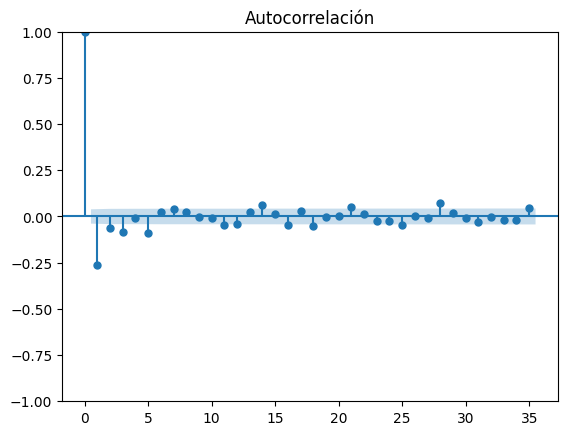

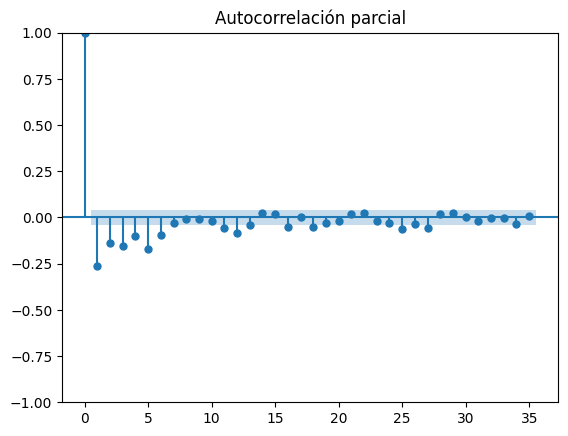

In [10]:
# Diferenciación para hacer la serie estacionaria (en caso de ser necesario)
df_consumos_precios['diferencia'] = df_consumos_precios['MBTU_daily'].diff()

plot_acf(df_consumos_precios['diferencia'].dropna())
plt.title('Autocorrelación')
plt.show()

plot_pacf(df_consumos_precios['diferencia'].dropna())
plt.title('Autocorrelación parcial')
plt.show()

In [11]:
def normalize_and_split_SARIMA(df, feature_col, exog_col, train_size_ratio=0.8):
    """
    Normaliza las columnas especificadas de un DataFrame y lo divide en conjuntos de entrenamiento y prueba.

    Parámetros:
    - df: pd.DataFrame
        El DataFrame que contiene los datos a normalizar.
    - feature_col: str
        Nombre de la columna de la variable de interés (MBTU_daily).
    - exog_col: str
        Nombre de la columna de la variable exógena (Precios_diarios).
    - train_size_ratio: float
        Proporción de datos a utilizar para el conjunto de entrenamiento (por defecto es 0.8).

    Retorna:
    - train: pd.Series
        Conjunto de datos de entrenamiento para la variable de interés.
    - test: pd.Series
        Conjunto de datos de prueba para la variable de interés.
    - scaler_gas: MinMaxScaler
        Scaler utilizado para la normalización de la variable de interés.
    - scaler_precios: MinMaxScaler
        Scaler utilizado para la normalización de la variable exógena.
    """
    # Inicializar los scalers
    scaler_gas = MinMaxScaler()
    scaler_precios = MinMaxScaler()

    # Normalizar las columnas especificadas
    df_consumos_scaler = scaler_gas.fit_transform(df[[feature_col]])
    df_consumos_scaler_precios = scaler_precios.fit_transform(df[[exog_col]])

    # Convertir los arrays escalados a DataFrame
    df_consumos_scaler = pd.DataFrame(df_consumos_scaler, columns=[feature_col])
    df_consumos_scaler_precios = pd.DataFrame(df_consumos_scaler_precios, columns=[exog_col])

    # Combinar los DataFrames normalizados
    df_combined = pd.concat([df_consumos_scaler, df_consumos_scaler_precios], axis=1)

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_combined) * train_size_ratio)
    train, test = df_combined[:train_size], df_combined[train_size:]

    return train, test, scaler_gas, scaler_precios


In [102]:
def create_dataset(data, exog, time_step=1, output_steps=1):
    """
    Crea conjuntos de datos para un modelo de series temporales a partir de un conjunto de datos y una variable exógena.

    Parámetros:
    - data: pd.DataFrame o np.ndarray
        Conjunto de datos que contiene los valores de interés (consumo).
        Se espera que los datos tengan al menos una columna.
    - exog: pd.DataFrame o np.ndarray
        Conjunto de datos que contiene la variable exógena a incluir en las entradas.
        Debe tener la misma cantidad de filas que 'data'.
    - time_step: int
        Número de pasos de tiempo a considerar para la creación de las entradas del modelo (por defecto es 1).
    - output_steps: int
        Número de pasos a predecir hacia adelante (por defecto es 1).

    Retorna:
    - X: np.ndarray
        Conjunto de datos de entrada, donde cada entrada es una secuencia de longitud `time_step`
        que incluye tanto los datos de consumo como la variable exógena.
    - y: np.ndarray
        Conjunto de datos de salida, que corresponde a los valores siguientes a cada secuencia de entrada del conjunto de datos principal.
    """
    X, y = [], []  # Inicializa las listas para las entradas y salidas

    # Iterar a través de los datos para crear las secuencias
    for i in range(len(data) - time_step - output_steps + 1):
        # Extraer el consumo y la variable exógena para el paso de tiempo actual
        X.append(np.concatenate((data[i:(i + time_step)], exog[i:(i + time_step)]), axis=1))
        # Añadir los valores de salida para los próximos 'output_steps'
        y.append(data[i + time_step:i + time_step + output_steps, 0])  # Saca los próximos valores

    return np.array(X), np.array(y)  # Convierte las listas a arrays de NumPy y los retorna

import numpy as np

def create_dataset_multiOut(dataset, n_steps_out=1, n_steps_in=1, overlap=1):
    dataX, dataY = [], []
    tem = n_steps_in + n_steps_out - overlap

    # Número de columnas de dataset
    n_features = dataset.shape[1]  # Esto incluye tanto la variable dependiente como las exógenas

    for i in range(int((len(dataset) - tem) / overlap)):
        startx = i * overlap
        endx = startx + n_steps_in
        starty = endx
        endy = endx + n_steps_out

        # Extraer los valores de la variable dependiente (target) y las variables exógenas
        a = dataset[startx:endx, 0]  # Primera columna: variable dependiente (target)
        exog_features = dataset[startx:endx, 1:]  # Las demás columnas: variables exógenas

        # Concatenar la variable dependiente con las variables exógenas para formar las entradas
        X = np.column_stack((a, exog_features))  # Esto crea las entradas con la variable dependiente y exógenas
        dataX.append(X)

        # Extraer la salida, que es la variable dependiente en los pasos futuros
        dataY.append(dataset[starty:endy, 0])

    return np.array(dataX), np.array(dataY)


def normalize_and_split_LSTM(df, feature_col, exog_col, train_size_ratio=0.7, val_size_ratio=0.15):
    """
    Normaliza las columnas especificadas de un DataFrame y lo divide en conjuntos de entrenamiento, validación y prueba.

    Parámetros:
    - df: pd.DataFrame
        El DataFrame que contiene los datos a normalizar.
    - feature_col: str
        Nombre de la columna de la variable de interés (MBTU_daily).
    - exog_col: str
        Nombre de la columna de la variable exógena (Precios_diarios).
    - train_size_ratio: float
        Proporción de datos a utilizar para el conjunto de entrenamiento (por defecto es 0.7).
    - val_size_ratio: float
        Proporción de datos a utilizar para el conjunto de validación (por defecto es 0.15).

    Retorna:
    - train: pd.DataFrame
        Conjunto de datos de entrenamiento.
    - val: pd.DataFrame
        Conjunto de datos de validación.
    - test: pd.DataFrame
        Conjunto de datos de prueba.
    - scaler_consumo: MinMaxScaler
        Scaler utilizado para la normalización de la variable de interés.
    - scaler_exog: MinMaxScaler
        Scaler utilizado para la normalización de la variable exógena.
    """
    # Normalizar la variable de interés
    scaler_consumo = MinMaxScaler(feature_range=(0, 1))
    df_consumos_scaler = scaler_consumo.fit_transform(df[[feature_col]])

    # Normalizar la variable exógena
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    df_consumos_scaler_precios = scaler_exog.fit_transform(df[[exog_col]])

    # Convertir los arrays escalados a DataFrame
    df_consumos_scaler = pd.DataFrame(df_consumos_scaler, columns=[feature_col])
    df_consumos_scaler_precios = pd.DataFrame(df_consumos_scaler_precios, columns=[exog_col])

    # Combinar los DataFrames normalizados
    df_selected = pd.concat([df_consumos_scaler, df_consumos_scaler_precios], axis=1)

    # Dividir el DataFrame en conjuntos de entrenamiento, validación y prueba
    train_size = int(len(df_selected) * train_size_ratio)
    val_size = int(len(df_selected) * val_size_ratio)

    train = df_selected[:train_size]
    val = df_selected[train_size:train_size + val_size]
    test = df_selected[train_size + val_size:]

    return train, val, test, scaler_consumo, scaler_exog

def create_datasets(train, val, test, time_step, output_steps):
    """
    Crea datasets para entrenamiento, validación y prueba a partir de los conjuntos divididos.

    Parámetros:
    - train: pd.DataFrame
        Conjunto de datos de entrenamiento.
    - val: pd.DataFrame
        Conjunto de datos de validación.
    - test: pd.DataFrame
        Conjunto de datos de prueba.
    - time_step: int
        Número de pasos de tiempo a utilizar en la creación de los datasets.
    - output_steps: int
        Número de pasos a predecir.

    Retorna:
    - X_train: np.ndarray
        Conjunto de datos de entrada para el entrenamiento.
    - y_train: np.ndarray
        Conjunto de datos de salida para el entrenamiento.
    - X_val: np.ndarray
        Conjunto de datos de entrada para la validación.
    - y_val: np.ndarray
        Conjunto de datos de salida para la validación.
    - X_test: np.ndarray
        Conjunto de datos de entrada para la prueba.
    - y_test: np.ndarray
        Conjunto de datos de salida para la prueba.
    """
    # Crear datasets a partir de las columnas normalizadas
    X_train, y_train = create_dataset(train[['MBTU_daily']].values, train[['Precios_diarios']].values, time_step, output_steps)
    X_val, y_val = create_dataset(val[['MBTU_daily']].values, val[['Precios_diarios']].values, time_step, output_steps)
    X_test, y_test = create_dataset(test[['MBTU_daily']].values, test[['Precios_diarios']].values, time_step, output_steps)

    # Remodelar para el formato adecuado del modelo LSTM [muestras, pasos de tiempo, características]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)  # 2 características: MBTU_daily y Precios_diarios
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 2)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [13]:
# Función para graficar resultados
def plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    train_predict_inv, val_predict_inv, test_predict_inv,
                    historia_LSTM, title='Predicciones vs Valores Reales'):
    """
    Función para graficar las métricas de evaluación y la evolución del error del modelo.

    Parámetros:
    - y_train_inv: np.ndarray
        Valores reales de entrenamiento.
    - y_val_inv: np.ndarray
        Valores reales de validación.
    - y_test_inv: np.ndarray
        Valores reales de prueba.
    - train_predict_inv: np.ndarray
        Predicciones del conjunto de entrenamiento.
    - val_predict_inv: np.ndarray
        Predicciones del conjunto de validación.
    - test_predict_inv: np.ndarray
        Predicciones del conjunto de prueba.
    - historia_LSTM: tf.keras.callbacks.History
        Historial del entrenamiento del modelo.
    - title: str
        Título del gráfico de predicciones.
    """

    # Métricas de evaluación
    rmse = np.sqrt(np.mean((test_predict_inv.flatten() - y_test_inv.flatten()) ** 2))
    mae = np.mean(np.abs(test_predict_inv.flatten() - y_test_inv.flatten()))
    mape = np.mean(np.abs((test_predict_inv.flatten() - y_test_inv.flatten()) / y_test_inv.flatten())) * 100

    print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
    print(f'Error Absoluto Medio (MAE): {mae:.2f}')
    print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

    # Crear un rango de tiempo para las gráficas
    train_len = len(y_train_inv)
    val_len = len(y_val_inv)
    test_len = len(y_test_inv)
    total_len = train_len + val_len + test_len

    # Crear un array de tiempo
    time = np.arange(total_len)

    # Crear un array para los valores originales
    values = np.concatenate((y_train_inv, y_val_inv, y_test_inv), axis=0)

    # Gráfico de predicciones vs valores reales
    plt.figure(figsize=(14, 7))
    plt.plot(time[:train_len], y_train_inv, label='Valores Reales Entrenamiento', color='blue')
    plt.plot(time[train_len:train_len + val_len], y_val_inv, label='Valores Reales Validación', color='orange')
    plt.plot(time[train_len + val_len:], y_test_inv, label='Valores Reales Prueba', color='green')
    # plt.plot(time[train_len:train_len + val_len], val_predict_inv, label='Predicciones Validación', color='red')
    plt.plot(time[train_len + val_len:], test_predict_inv, label='Predicciones Prueba', color='magenta')

    # Configuración del gráfico
    plt.title(title)
    plt.xlabel('Tiempo')
    plt.ylabel('MBTU Diario')
    plt.legend()
    #plt.xlim(0, total_len)
    # Fijar limites para el eje x de la grafica
    plt.xlim(2100, 2500)
    plt.show()

    # Gráfico de la evolución del error
    loss_values = historia_LSTM.history['loss']
    val_loss_values = historia_LSTM.history['val_loss']

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_values) + 1), loss_values, label='Error (MSE Entrenamiento)')
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Error (MSE Validación)', linestyle='--')
    plt.xlabel('Épocas')
    plt.ylabel('Error (MSE)')
    plt.title('Evolución del error del model con validación')
    plt.legend()
    plt.show()

## **Parte 4.** Modelación con SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                          MBTU_daily   No. Observations:                 2044
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 7)   Log Likelihood                2357.238
Date:                             Fri, 22 Nov 2024   AIC                          -4698.475
Time:                                     02:50:04   BIC                          -4653.521
Sample:                                          0   HQIC                         -4681.984
                                            - 2044                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Precios_diarios     0.8874      0.077     11.511      0.000       0.736       1.038
ar.L1       

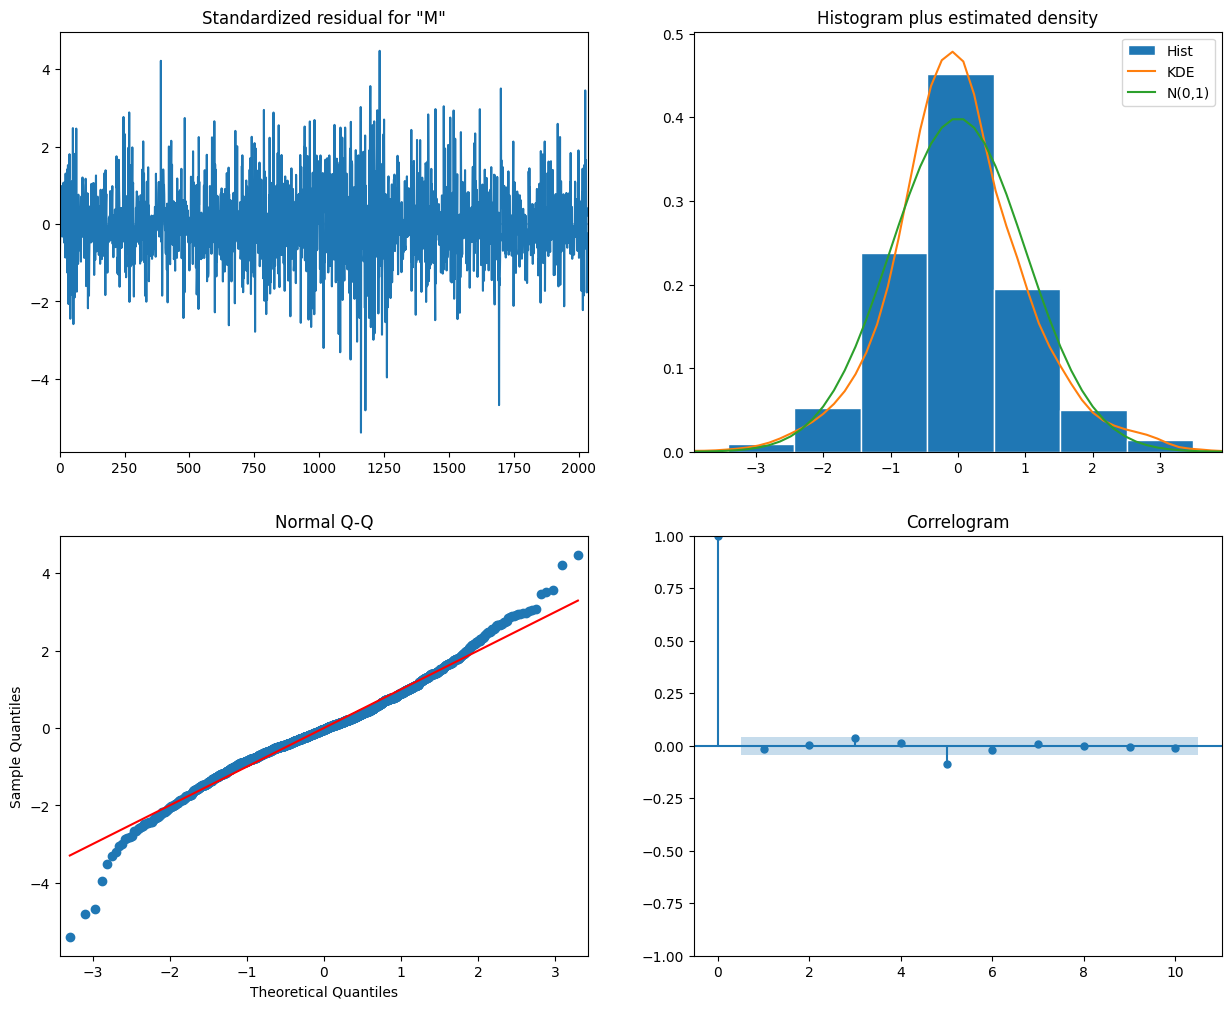

In [65]:

# Separación de datos
size_SARIMA = 0.8  # Proporción de datos para el conjunto de entrenamiento

# Normalizar y dividir los datos
train, test, scaler_gas, scaler_precios = normalize_and_split_SARIMA(df_consumos_precios, 'MBTU_daily', 'Precios_diarios',train_size_ratio = size_SARIMA)

# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 7  # Frecuencia s = 7 para periodos semanales.

# Ajustar el modelo con la variable exógena
model_simple = SARIMAX(train['MBTU_daily'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s))

# Ajustar el modelo con la variable exógena
model_exog = SARIMAX(train['MBTU_daily'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=train['Precios_diarios'])

results_simple = model_simple.fit()
results = model_exog.fit()

# Resumen del modelo
print(results.summary())

# Gráficos de diagnóstico
results.plot_diagnostics(figsize=(15, 12))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Raíz del Error Cuadrático Medio (RMSE): 43204.75
Error Absoluto Medio (MAE): 35852.49
Error Porcentual Absoluto Medio (MAPE): 21.84%


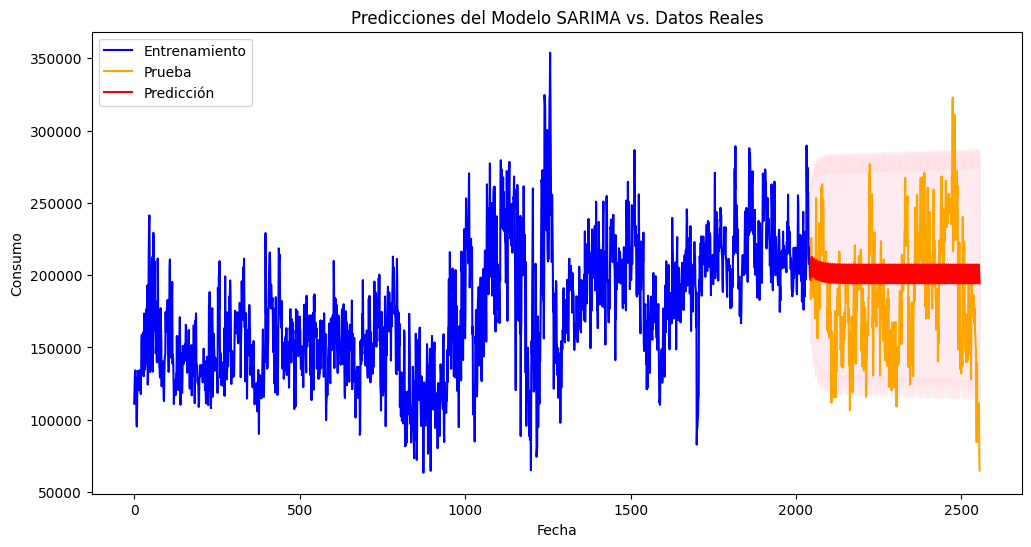

In [101]:
# Predicción futura
# Hacer predicciones sobre el conjunto de prueba
# Invertir el escalado de los datos de entrenamiento y prueba
train_inverso = scaler_gas.inverse_transform(train['MBTU_daily'].values.reshape(-1, 1))
test_inverso = scaler_gas.inverse_transform(test['MBTU_daily'].values.reshape(-1, 1))

# Invertir el escalado de las predicciones
pred_simple = results_simple.get_forecast(steps=len(test))
pred_conf_simple = pred_simple.conf_int()

predicciones_inversas_simple = scaler_gas.inverse_transform(pred_simple.predicted_mean.values.reshape(-1, 1))

# Predicciones y valores reales
predicciones = predicciones_inversas_simple.flatten()
valores_reales = test_inverso.flatten()

# Calcular las métricas
rmse = np.sqrt(np.mean((predicciones - valores_reales) ** 2))
mae = np.mean(np.abs(predicciones - valores_reales))
mape = np.mean(np.abs((predicciones - valores_reales) / valores_reales)) * 100

# Mostrar las métricas
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Visualizar predicciones
plt.figure(figsize=(12, 6))
# Graficar datos de entrenamiento
plt.plot(train_inverso, label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(pred_simple.predicted_mean.index, test_inverso, label='Prueba', color='orange')

# Graficar predicciones
plt.plot(pred_simple.predicted_mean.index, predicciones_inversas_simple, label='Predicción', color='red')

# Graficar intervalos de confianza
plt.fill_between(pred_conf_simple.index,
                 scaler_gas.inverse_transform(pred_conf_simple.iloc[:, 0].values.reshape(-1, 1)).flatten(),
                 scaler_gas.inverse_transform(pred_conf_simple.iloc[:, 1].values.reshape(-1, 1)).flatten(),
                 color='pink', alpha=0.3)

# Configuración del gráfico
plt.title('Predicciones del Modelo SARIMA vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Raíz del Error Cuadrático Medio (RMSE): 115854.03
Error Absoluto Medio (MAE): 105822.00
Error Porcentual Absoluto Medio (MAPE): 60.69%


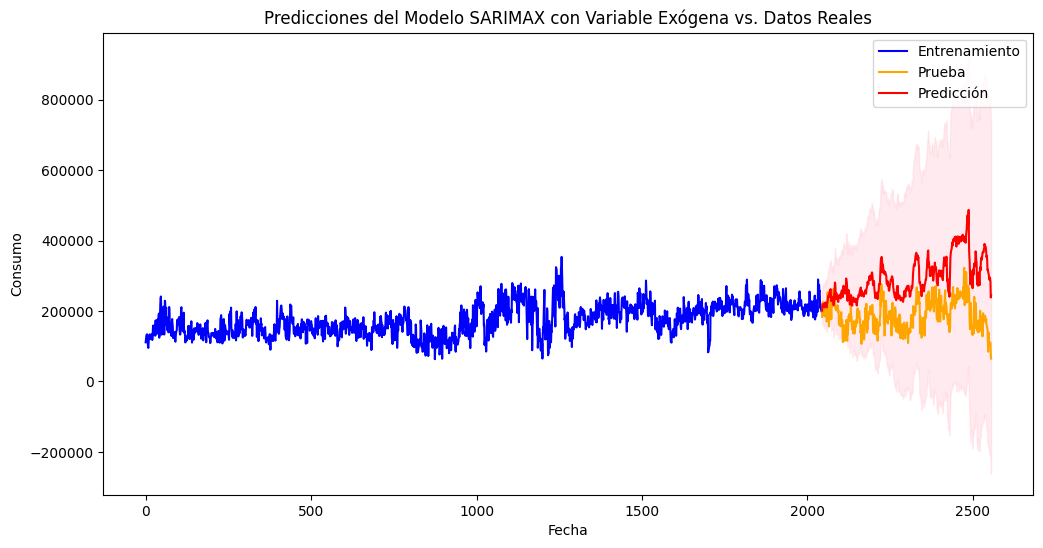

In [67]:
# Predicción futura
# Hacer predicciones sobre el conjunto de prueba
pred = results.get_forecast(steps=len(test), exog=test['Precios_diarios'])
pred_conf = pred.conf_int()

# Evaluación del modelo.
predicciones_inversas = scaler_gas.inverse_transform(pred.predicted_mean.values.reshape(-1, 1))

# Predicciones y valores reales
predicciones = predicciones_inversas.flatten()
valores_reales = test_inverso.flatten()

# Calcular las métricas
rmse = np.sqrt(np.mean((predicciones - valores_reales) ** 2))
mae = np.mean(np.abs(predicciones - valores_reales))
mape = np.mean(np.abs((predicciones - valores_reales) / valores_reales)) * 100

# Mostrar las métricas
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

# Visualizar predicciones
plt.figure(figsize=(12, 6))
# Graficar datos de entrenamiento
plt.plot(train_inverso, label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(pred.predicted_mean.index, test_inverso, label='Prueba', color='orange')

# Graficar predicciones
plt.plot(pred.predicted_mean.index, predicciones_inversas, label='Predicción', color='red')

# Graficar intervalos de confianza
plt.fill_between(pred_conf.index,
                 scaler_gas.inverse_transform(pred_conf.iloc[:, 0].values.reshape(-1, 1)).flatten(),
                 scaler_gas.inverse_transform(pred_conf.iloc[:, 1].values.reshape(-1, 1)).flatten(),
                 color='pink', alpha=0.3)

# Configuración del gráfico
plt.title('Predicciones del Modelo SARIMAX con Variable Exógena vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

## **Parte 5.** Modelación con Red Neural LSTM

In [104]:
# Separación de datos
time_step = 7  # Define el paso de tiempo que usarás en el modelo
output_steps = 1  # Número de pasos a predecir hacia adelante
size = 0.7  # Proporción de datos para el conjunto de entrenamiento
val_size = 0.1  # Proporción de datos para el conjunto de validación

# Establecer semilla
seed_value = 42
tf.random.set_seed(seed_value)  # Para TensorFlow

# Normalizar y dividir los datos
train_LSTM, val_LSTM, test_LSTM, scaler_consumo, scaler_exog = normalize_and_split_LSTM(df_consumos_precios, 'MBTU_daily', 'Precios_diarios', train_size_ratio=size, val_size_ratio=val_size)

# Crear los datasets para el modelo
X_train, y_train, X_val, y_val, X_test, y_test = create_datasets(train_LSTM, val_LSTM, test_LSTM, time_step, output_steps)

# Seleccionar la primera columna de la última dimensión, no incluir la variable exógena.
X_train_mbtu = X_train[:, :, 0]
X_val_mbtu = X_val[:, :, 0]
X_test_mbtu = X_test[:, :, 0]


In [69]:

# Crear el modelo LSTM
model_LSTM_ini = Sequential()
model_LSTM_ini.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_LSTM_ini.add(Dropout(0.2))
model_LSTM_ini.add(LSTM(50, return_sequences=False))
model_LSTM_ini.add(Dropout(0.2))
model_LSTM_ini.add(Dense(output_steps))  # predicción de múltiples valores

model_LSTM_ini.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con validación
historia_LSTM_ini = model_LSTM_ini.fit(X_train_mbtu, y_train, epochs=20, batch_size=32, validation_data=(X_val_mbtu, y_val), verbose=2)

# Hacer predicciones
train_predict_LSTM_ini = model_LSTM_ini.predict(X_train_mbtu)
val_predict_LSTM_ini = model_LSTM_ini.predict(X_val_mbtu)
test_predict_LSTM_ini = model_LSTM_ini.predict(X_test_mbtu)

# Invertir la normalización para volver a los valores originales
train_predict_inv_LSTM_ini = scaler_consumo.inverse_transform(train_predict_LSTM_ini)
val_predict_inv_LSTM_ini = scaler_consumo.inverse_transform(val_predict_LSTM_ini)
test_predict_inv_LSTM_ini = scaler_consumo.inverse_transform(test_predict_LSTM_ini)

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train)
y_val_inv = scaler_consumo.inverse_transform(y_val)
y_test_inv = scaler_consumo.inverse_transform(y_test)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
56/56 - 5s - 97ms/step - loss: 0.0257 - val_loss: 0.0119
Epoch 2/20
56/56 - 1s - 10ms/step - loss: 0.0111 - val_loss: 0.0069
Epoch 3/20
56/56 - 1s - 10ms/step - loss: 0.0110 - val_loss: 0.0065
Epoch 4/20
56/56 - 1s - 11ms/step - loss: 0.0106 - val_loss: 0.0061
Epoch 5/20
56/56 - 1s - 11ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 6/20
56/56 - 1s - 10ms/step - loss: 0.0097 - val_loss: 0.0059
Epoch 7/20
56/56 - 1s - 11ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 8/20
56/56 - 1s - 10ms/step - loss: 0.0096 - val_loss: 0.0053
Epoch 9/20
56/56 - 1s - 11ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 10/20
56/56 - 1s - 11ms/step - loss: 0.0094 - val_loss: 0.0053
Epoch 11/20
56/56 - 1s - 10ms/step - loss: 0.0090 - val_loss: 0.0049
Epoch 12/20
56/56 - 1s - 11ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 13/20
56/56 - 1s - 10ms/step - loss: 0.0086 - val_loss: 0.0050
Epoch 14/20
56/56 - 1s - 11ms/step - loss: 0.0085 - val_loss: 0.0048
Epoch 15/20
56/56 - 1s - 11ms/step - loss: 

In [70]:
# resumen arquitectura propuesta
model_LSTM_ini.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 7, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

Raíz del Error Cuadrático Medio (RMSE): 24153.13
Error Absoluto Medio (MAE): 18420.83
Error Porcentual Absoluto Medio (MAPE): 10.32%


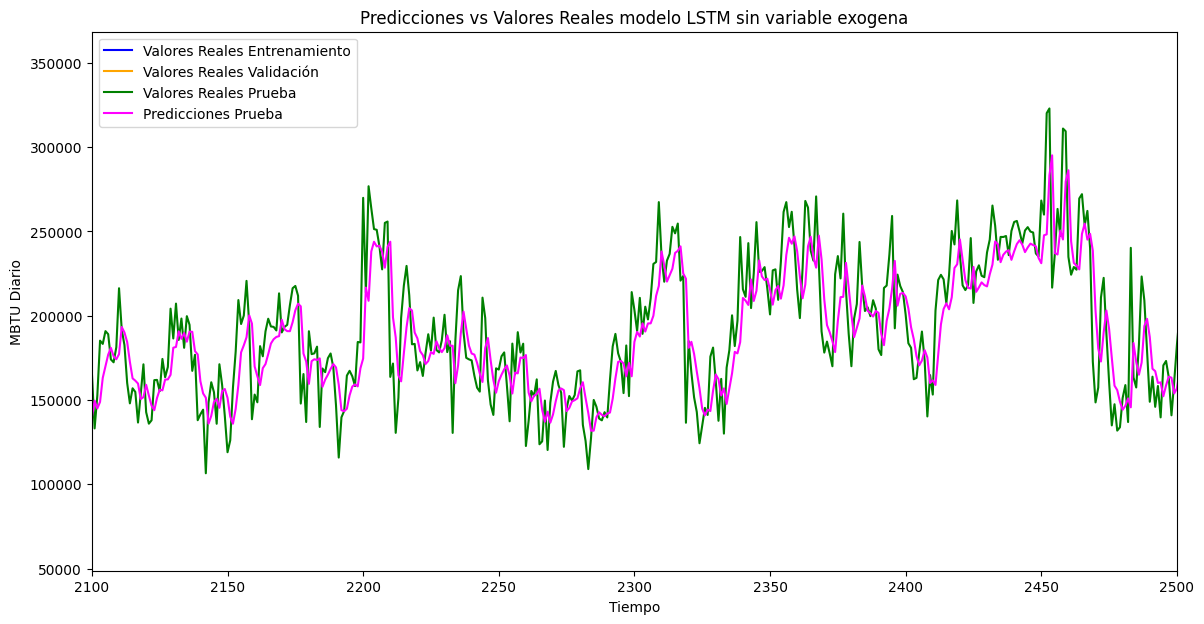

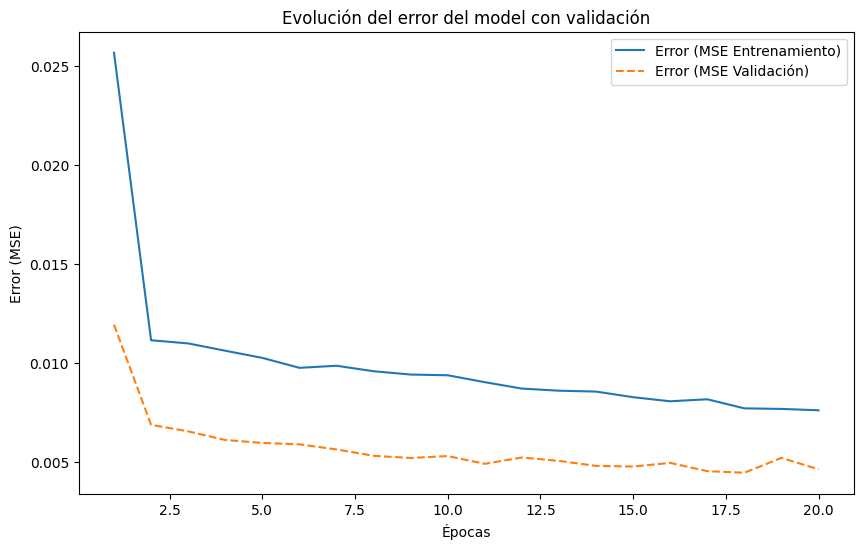

In [71]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    train_predict_inv_LSTM_ini, val_predict_inv_LSTM_ini, test_predict_inv_LSTM_ini,
                    historia_LSTM_ini, title='Predicciones vs Valores Reales modelo LSTM sin variable exogena')

In [72]:
# Construir el modelo LSTM
model_LSTM_exog = Sequential()
model_LSTM_exog.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 2)))  # Cambiar a 2 para incluir la exógena
model_LSTM_exog.add(Dropout(0.2))
model_LSTM_exog.add(LSTM(units=50, return_sequences=False))
model_LSTM_exog.add(Dropout(0.2))
model_LSTM_exog.add(Dense(output_steps))  # Predicción de varios valores.

# Compilar el modelo
model_LSTM_exog.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_LSTM_exog = model_LSTM_exog.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Hacer predicciones
train_predict_LSTM_exog = model_LSTM_exog.predict(X_train)
val_predict_LSTM_exog = model_LSTM_exog.predict(X_val)
test_predict_LSTM_exog = model_LSTM_exog.predict(X_test)

# Invertir la normalización para volver a los valores originales
train_predict_inv_LSTM_exog = scaler_consumo.inverse_transform(train_predict_LSTM_exog)
val_predict_inv_LSTM_exog = scaler_consumo.inverse_transform(val_predict_LSTM_exog)
test_predict_inv_LSTM_exog = scaler_consumo.inverse_transform(test_predict_LSTM_exog)

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train)
y_val_inv = scaler_consumo.inverse_transform(y_val)
y_test_inv = scaler_consumo.inverse_transform(y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Raíz del Error Cuadrático Medio (RMSE): 24428.27
Error Absoluto Medio (MAE): 18748.98
Error Porcentual Absoluto Medio (MAPE): 10.97%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


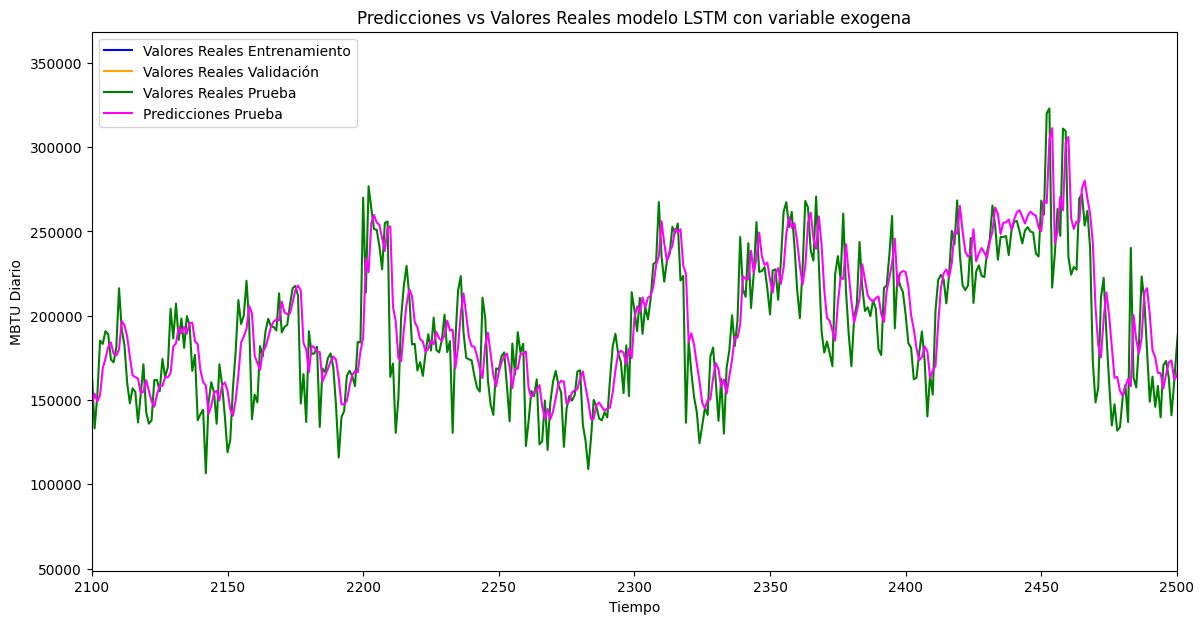

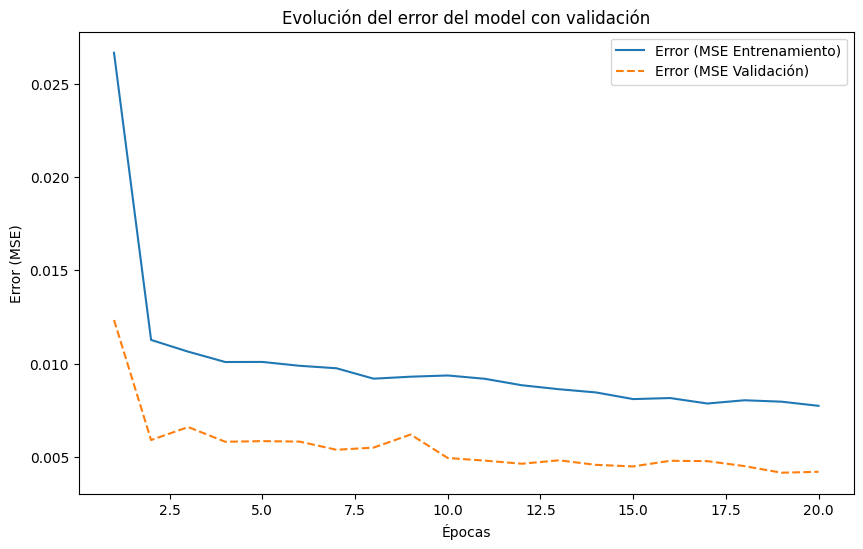

In [73]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    train_predict_inv_LSTM_exog, val_predict_inv_LSTM_exog, test_predict_inv_LSTM_exog,
                    historia_LSTM_exog, title='Predicciones vs Valores Reales modelo LSTM con variable exogena')

## **Parte 5.** Modelación con Red Neural GRU con y sin variable exogena.

In [74]:
# Construir el modelo GRU
model_GRU_ini = Sequential()
model_GRU_ini.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # 1 característica
model_GRU_ini.add(Dropout(0.2))
model_GRU_ini.add(GRU(units=50, return_sequences=False))
model_GRU_ini.add(Dropout(0.2))
model_GRU_ini.add(Dense(output_steps))  # Predicción de los valores

# Compilar el modelo
model_GRU_ini.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_GRU_ini = model_GRU_ini.fit(X_train_mbtu, y_train, epochs=20, batch_size=32, validation_data=(X_val_mbtu, y_val), verbose=0)

# Hacer predicciones
train_predict_GRU_ini = model_GRU_ini.predict(X_train_mbtu)
val_predict_GRU_ini = model_GRU_ini.predict(X_val_mbtu)
test_predict_GRU_ini = model_GRU_ini.predict(X_test_mbtu)

# Invertir la normalización
train_predict_GRU_ini = scaler_consumo.inverse_transform(train_predict_GRU_ini)
val_predict_GRU_ini = scaler_consumo.inverse_transform(val_predict_GRU_ini)
test_predict_GRU_ini = scaler_consumo.inverse_transform(test_predict_GRU_ini)

# Obtener los valores reales
y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Raíz del Error Cuadrático Medio (RMSE): 23812.02
Error Absoluto Medio (MAE): 18165.21
Error Porcentual Absoluto Medio (MAPE): 10.02%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


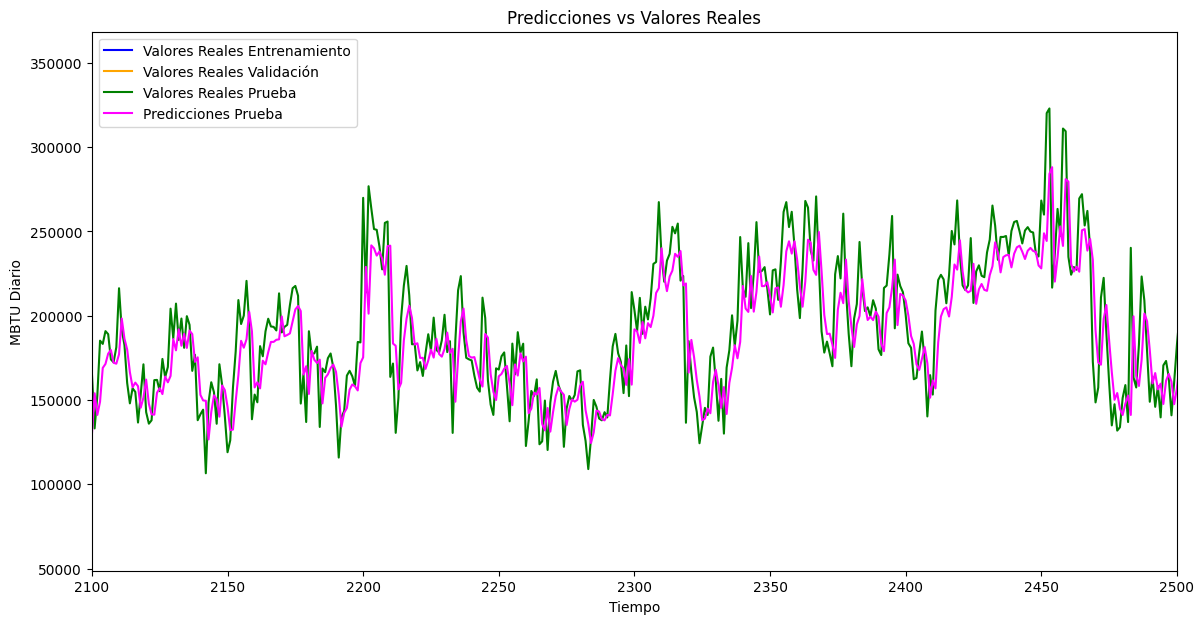

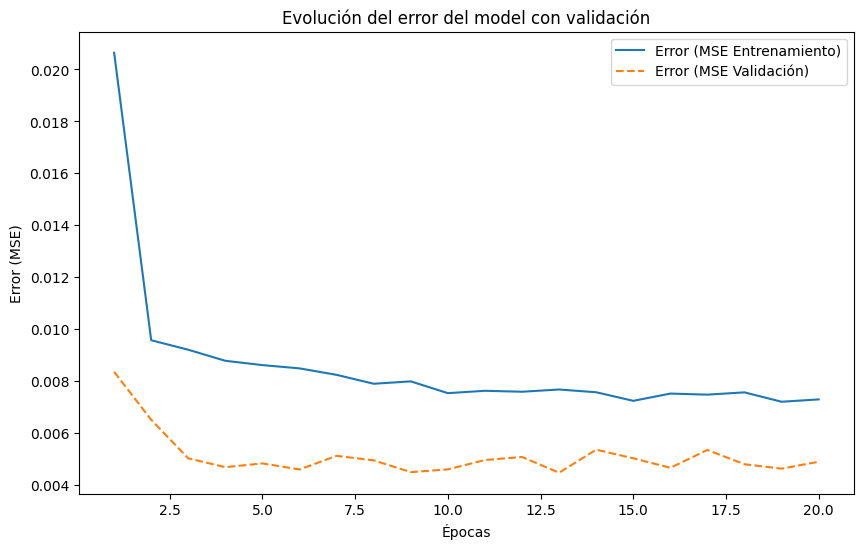

In [75]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    train_predict_GRU_ini, val_predict_GRU_ini, test_predict_GRU_ini,
                    historia_GRU_ini, title='Predicciones vs Valores Reales')

In [76]:
# Construir el modelo GRU con variable exogena
model_GRU_exog = Sequential()
model_GRU_exog.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))  # 2 características, inclusión de la variable exógena.
model_GRU_exog.add(Dropout(0.2))
model_GRU_exog.add(GRU(units=50, return_sequences=False))
model_GRU_exog.add(Dropout(0.2))
model_GRU_exog.add(Dense(output_steps))  # Predicción de un valor

# Compilar el modelo
model_GRU_exog.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_GRU_exog = model_GRU_exog.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Hacer predicciones
train_predict_GRU_exog = model_GRU_exog.predict(X_train)
val_predict_GRU_exog = model_GRU_exog.predict(X_val)
test_predict_GRU_exog = model_GRU_exog.predict(X_test)

# Invertir la normalización
train_predict_GRU_exog = scaler_consumo.inverse_transform(train_predict_GRU_exog)  # Invertir la normalización
val_predict_GRU_exog = scaler_consumo.inverse_transform(val_predict_GRU_exog)  # Invertir la normalización
test_predict_GRU_exog = scaler_consumo.inverse_transform(test_predict_GRU_exog)  # Invertir la normalización

# Obtener los valores reales
y_train_inv = scaler_consumo.inverse_transform(y_train.reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Raíz del Error Cuadrático Medio (RMSE): 22658.79
Error Absoluto Medio (MAE): 17262.54
Error Porcentual Absoluto Medio (MAPE): 9.86%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


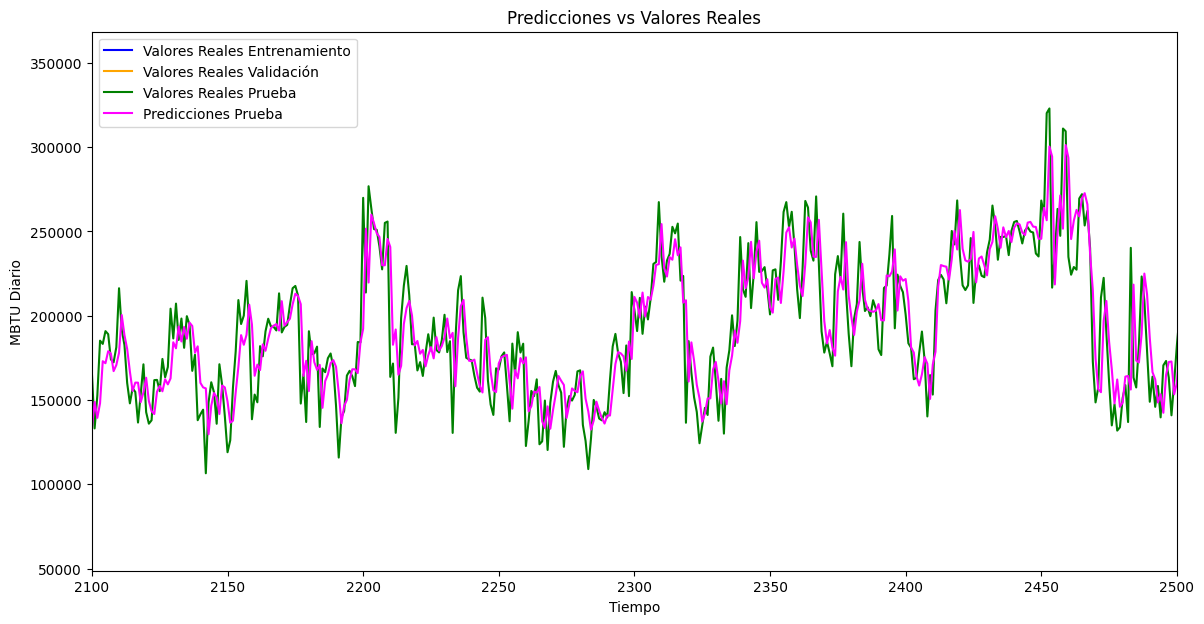

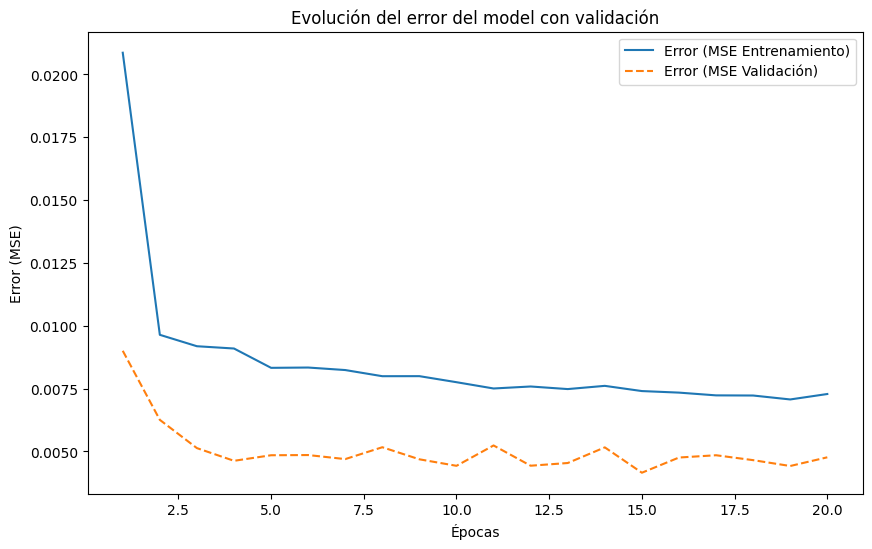

In [77]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    train_predict_GRU_exog, val_predict_GRU_exog, test_predict_GRU_exog,
                    historia_GRU_exog, title='Predicciones vs Valores Reales')

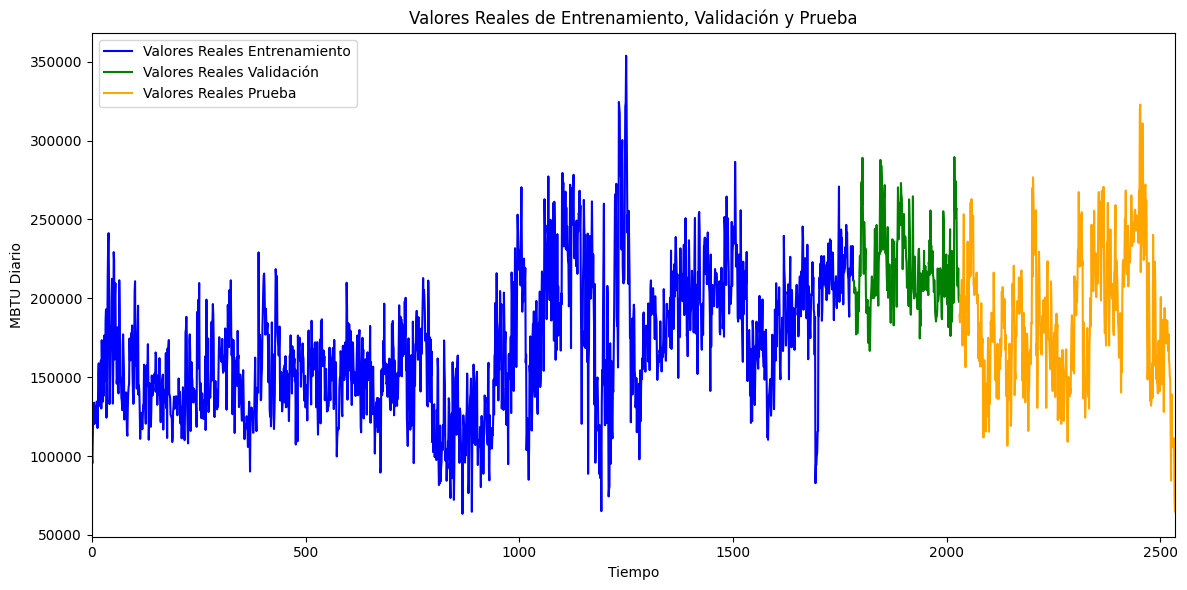

In [78]:
# Grafico de valores de entrenamiento, validación y prueba
# Crear un array para los valores originales
# Crear un rango de tiempo para las gráficas
train_len = len(y_train_inv)
val_len = len(y_val_inv)
test_len = len(y_test_inv)
total_len = train_len + val_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

values = np.concatenate((y_train_inv, y_val_inv, y_test_inv), axis=0)

# Crear la figura para el único gráfico
plt.figure(figsize=(12, 6))

# Graficar los valores reales de entrenamiento, validación y prueba
plt.plot(time[:train_len], y_train_inv, label='Valores Reales Entrenamiento', color='blue')
plt.plot(time[train_len:train_len + val_len], y_val_inv, label='Valores Reales Validación', color='green')
plt.plot(time[train_len + val_len:], y_test_inv, label='Valores Reales Prueba', color='orange')

# Configuración del gráfico
plt.title('Valores Reales de Entrenamiento, Validación y Prueba')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.xlim(0, total_len)  # Asegúrate de que `total_len` esté definido correctamente
plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [79]:
len(predicciones_inversas[train_len + val_len:])

0

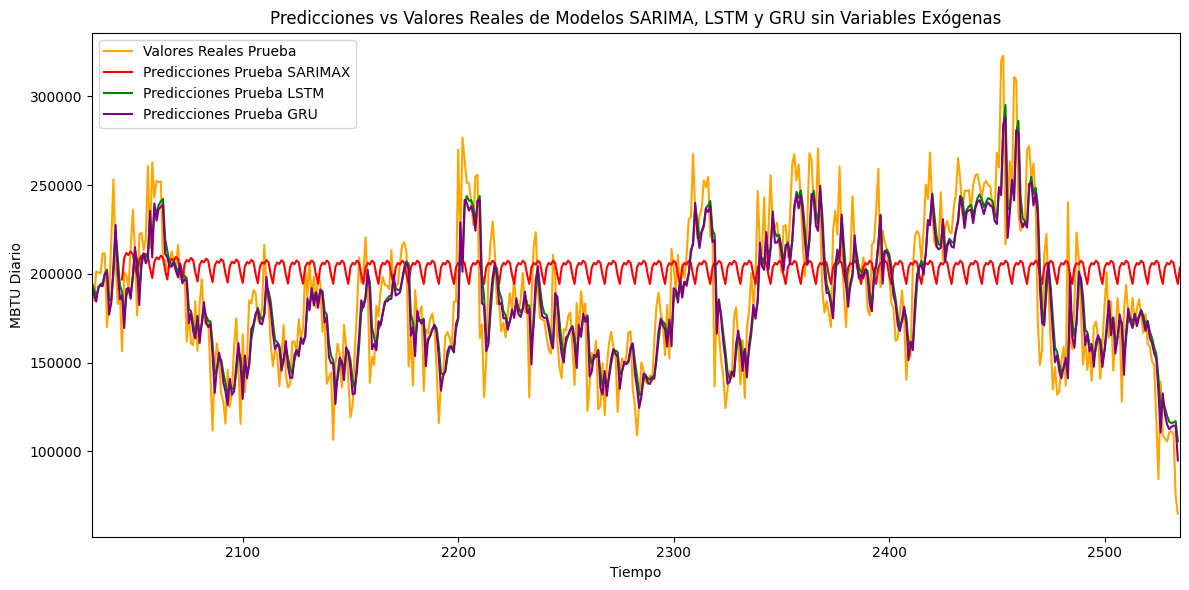

In [80]:
# Graficas consolidadas de primera parte del trabajo

# Crear un rango de tiempo para las gráficas
train_len = len(y_train_inv)
val_len = len(y_val_inv)
test_len = len(y_test_inv)
total_len = train_len + val_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

# Crear un array para los valores originales
values = np.concatenate((y_train_inv, y_val_inv, y_test_inv), axis=0)

# Crear la figura y el único gráfico
plt.figure(figsize=(12, 6))

# Graficar datos de entrenamiento, prueba y predicciones para el primer modelo

plt.plot(time[train_len + val_len:], y_test_inv, label='Valores Reales Prueba', color='orange')
#plt.plot(pred_simple.predicted_mean.index, test_inverso, label='Prueba', color='orange')
plt.plot(pred_simple.predicted_mean.index, predicciones_inversas_simple, label='Predicciones Prueba SARIMAX', color='red')


#plt.plot(time[train_len:train_len + val_len], val_predict_inv_LSTM_exog, label='Predicciones Validación LSTM', color='red')
plt.plot(time[train_len + val_len:], test_predict_inv_LSTM_ini, label='Predicciones Prueba LSTM', color='green')

# Graficar predicciones del tercer modelo (GRU con exógena)
#plt.plot(time[train_len:train_len + val_len], val_predict_GRU_exog, label='Predicciones Validación GRU', color='purple')
plt.plot(time[train_len + val_len:], test_predict_GRU_ini, label='Predicciones Prueba GRU', color='purple')

# Configuración del gráfico
plt.title('Predicciones vs Valores Reales de Modelos SARIMA, LSTM y GRU sin Variables Exógenas')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
#plt.xlim(0, total_len)
# Fijar limites para el eje x de la grafica
plt.xlim(train_len + val_len, total_len)
plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico combinado
plt.show()




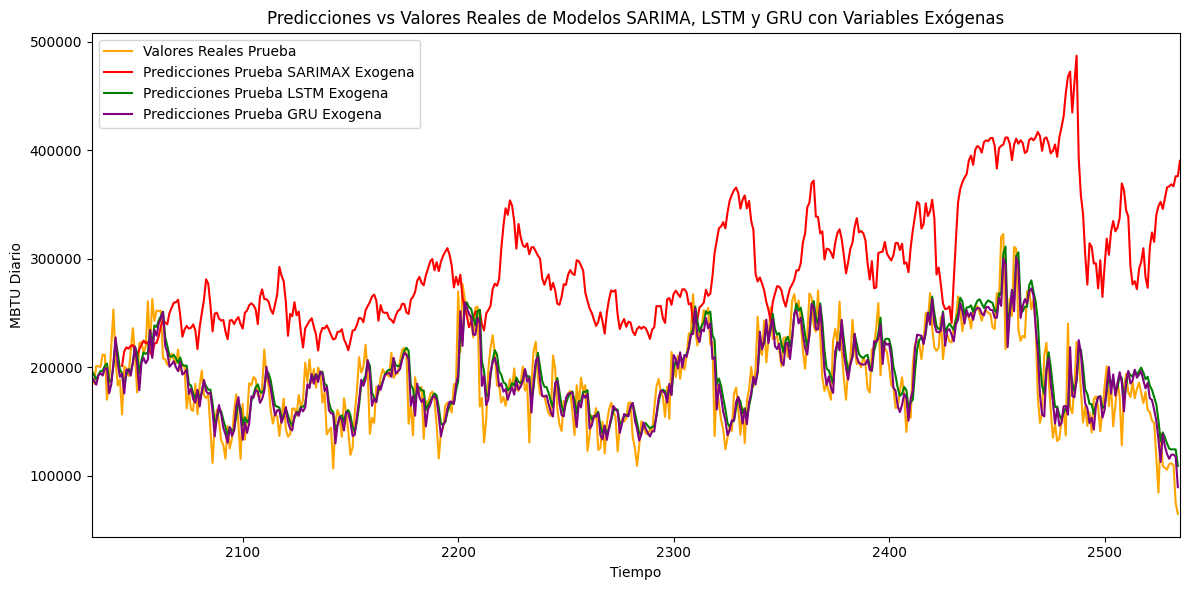

In [81]:
# Graficas consolidadas de primera parte del trabajo

# Crear un rango de tiempo para las gráficas
train_len = len(y_train_inv)
val_len = len(y_val_inv)
test_len = len(y_test_inv)
total_len = train_len + val_len + test_len

# Crear un array de tiempo
time = np.arange(total_len)

# Crear un array para los valores originales
values = np.concatenate((y_train_inv, y_val_inv, y_test_inv), axis=0)

# Crear la figura y el único gráfico
plt.figure(figsize=(12, 6))

# Graficar datos de entrenamiento, prueba y predicciones para el primer modelo

plt.plot(time[train_len + val_len:], y_test_inv, label='Valores Reales Prueba', color='orange')
#plt.plot(pred_simple.predicted_mean.index, test_inverso, label='Prueba', color='orange')
plt.plot(pred_simple.predicted_mean.index, predicciones_inversas, label='Predicciones Prueba SARIMAX Exogena', color='red')


#plt.plot(time[train_len:train_len + val_len], val_predict_inv_LSTM_exog, label='Predicciones Validación LSTM', color='red')
plt.plot(time[train_len + val_len:], test_predict_inv_LSTM_exog, label='Predicciones Prueba LSTM Exogena', color='green')

# Graficar predicciones del tercer modelo (GRU con exógena)
#plt.plot(time[train_len:train_len + val_len], val_predict_GRU_exog, label='Predicciones Validación GRU', color='purple')
plt.plot(time[train_len + val_len:], test_predict_GRU_exog, label='Predicciones Prueba GRU Exogena', color='purple')

# Configuración del gráfico
plt.title('Predicciones vs Valores Reales de Modelos SARIMA, LSTM y GRU con Variables Exógenas')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
#plt.xlim(0, total_len)
# Fijar limites para el eje x de la grafica
plt.xlim(train_len + val_len, total_len)
plt.legend()
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico combinado
plt.show()




In [82]:
1=0

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (<ipython-input-82-71c6896b3026>, line 1)

In [83]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

from local.lib import DataPreparationRNN

### **Pruebas en LSTM y GRU con diferentes predicciones de pasos hacia adelante, sin variable exogena**

In [155]:
# Separación de datos sin sobrelapamientos.
time_step = 7  # Define el paso de tiempo que usarás en el modelo
output_steps = 7  # Número de pasos a predecir hacia adelante
size = 0.7  # Proporción de datos para el conjunto de entrenamiento
val_size = 0.1  # Proporción de datos para el conjunto de validación

# Establecer semilla
seed_value = 42
tf.random.set_seed(seed_value)  # Para TensorFlow

# Normalizar y dividir los datos
train_LSTM, val_LSTM, test_LSTM, scaler_consumo, scaler_exog = normalize_and_split_LSTM(df_consumos_precios, 'MBTU_daily', 'Precios_diarios', train_size_ratio=size, val_size_ratio=val_size)

#Convertir datos a array
train_LSTM = np.array(train_LSTM)
val_LSTM = np.array(val_LSTM)
test_LSTM = np.array(test_LSTM)

X_train, y_train = create_dataset_multiOut(train_LSTM, output_steps, time_step,  output_steps)
X_val, y_val = create_dataset_multiOut(val_LSTM, output_steps, time_step, output_steps)
X_test, y_test = create_dataset_multiOut(test_LSTM, output_steps, time_step, output_steps)

X_train = X_train[:, :, 0]
X_val = X_val[:, :, 0]
X_test = X_test[:, :, 0]

# X_train, y_train = DataPreparationRNN.create_datasetMultipleTimesBackAhead(train_LSTM, n_steps_out = output_steps, n_steps_in = time_step, overlap = output_steps)
# X_val, y_val = DataPreparationRNN.create_datasetMultipleTimesBackAhead(val_LSTM, n_steps_out = output_steps, n_steps_in = time_step, overlap = output_steps)
# X_test, y_test = DataPreparationRNN.create_datasetMultipleTimesBackAhead(test_LSTM, n_steps_out = output_steps, n_steps_in = time_step, overlap = output_steps)


In [156]:
# Crear el modelo LSTM
model_LSTM_multiOut = Sequential()
model_LSTM_multiOut.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_LSTM_multiOut.add(Dropout(0.2))
model_LSTM_multiOut.add(LSTM(50, return_sequences=False))
model_LSTM_multiOut.add(Dropout(0.2))
model_LSTM_multiOut.add(Dense(output_steps))  # predicción de múltiples valores

model_LSTM_multiOut.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con validación
historia_LSTM_multiOut = model_LSTM_multiOut.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Hacer predicciones
trainPredict = model_LSTM_multiOut.predict(X_train.reshape(X_train.shape[0], time_step))
valPredict = model_LSTM_multiOut.predict(X_val.reshape(X_val.shape[0], time_step))
testPredict = model_LSTM_multiOut.predict(X_test.reshape(X_test.shape[0], time_step))

# Invertir la normalización para volver a los valores originales
trainPredict_inv_multioutLSTM = scaler_consumo.inverse_transform(trainPredict.flatten().reshape(-1, 1))
valPredict_inv_multioutLSTM = scaler_consumo.inverse_transform(valPredict.flatten().reshape(-1, 1))
testPredict_inv_multioutLSTM = scaler_consumo.inverse_transform(testPredict.flatten().reshape(-1, 1))

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train.flatten().reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.flatten().reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.flatten().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Raíz del Error Cuadrático Medio (RMSE): 34695.50
Error Absoluto Medio (MAE): 27252.07
Error Porcentual Absoluto Medio (MAPE): 14.60%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


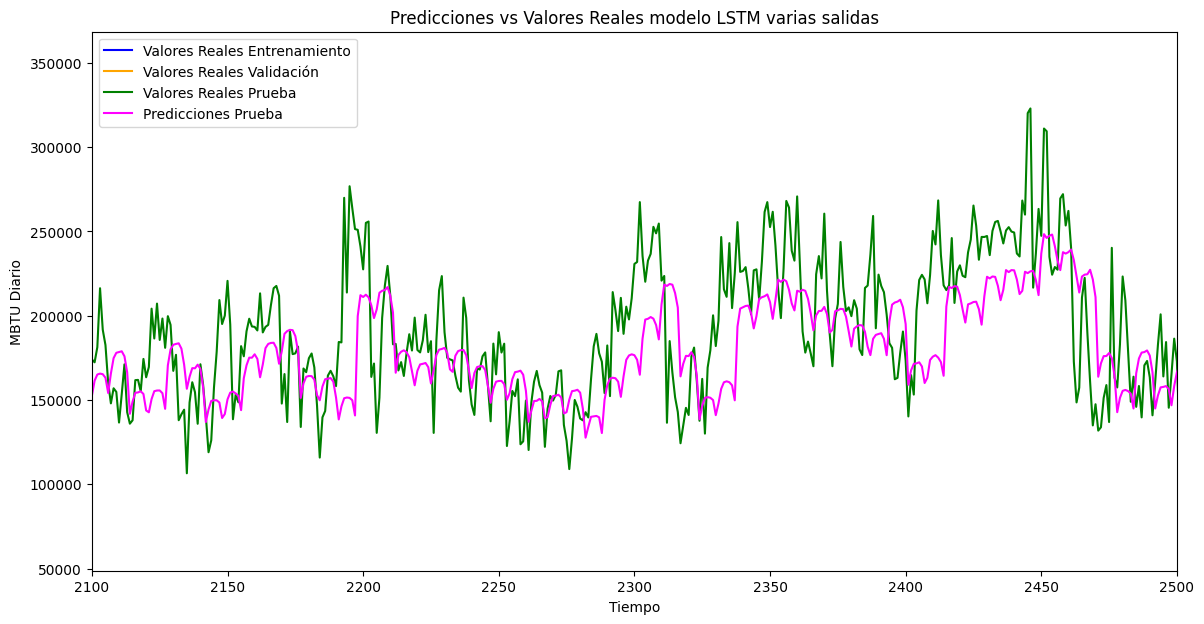

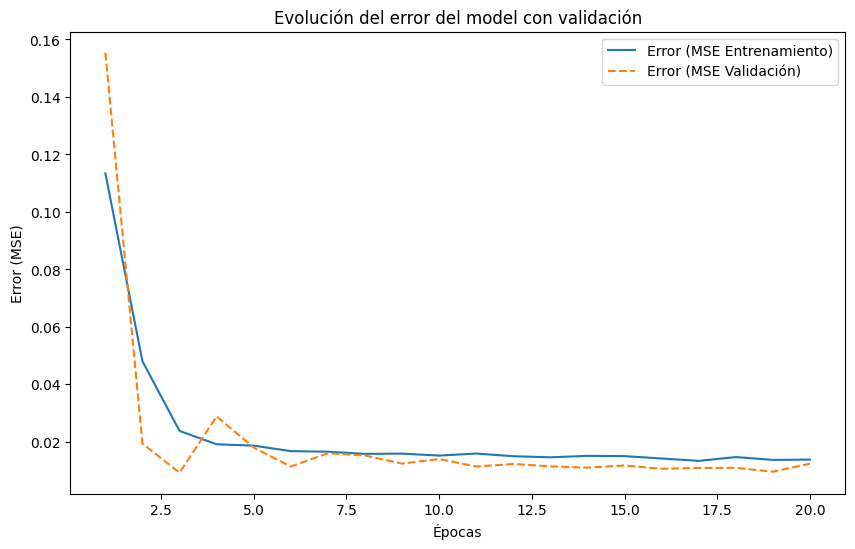

In [157]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    trainPredict_inv_multioutLSTM, valPredict_inv_multioutLSTM, testPredict_inv_multioutLSTM,
                    historia_LSTM_multiOut, title='Predicciones vs Valores Reales modelo LSTM varias salidas')

### Predicciones hacia adelante con modelo GRU

In [158]:
# Construir el modelo GRU
from keras import regularizers
model_GRU_multiOut = Sequential()
model_GRU_multiOut.add(GRU(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1),  bias_regularizer=regularizers.L1L2(1e-3)))
model_GRU_multiOut.add(Dropout(0.2))
model_GRU_multiOut.add(GRU(units=70, return_sequences=False, bias_regularizer=regularizers.L1L2(1e-3)))
model_GRU_multiOut.add(Dropout(0.2))
model_GRU_multiOut.add(Dense(output_steps))  # Predicción de los valores

# Compilar el modelo
model_GRU_multiOut.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_GRU_multiOut = model_GRU_multiOut.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Hacer predicciones
trainPredict = model_GRU_multiOut.predict(X_train.reshape(X_train.shape[0], time_step))
valPredict = model_GRU_multiOut.predict(X_val.reshape(X_val.shape[0], time_step))
testPredict = model_GRU_multiOut.predict(X_test.reshape(X_test.shape[0], time_step))

# Invertir la normalización para volver a los valores originales
trainPredict_inv_multioutGRU = scaler_consumo.inverse_transform(trainPredict.flatten().reshape(-1, 1))
valPredict_inv_multioutGRU = scaler_consumo.inverse_transform(valPredict.flatten().reshape(-1, 1))
testPredict_inv_multioutGRU = scaler_consumo.inverse_transform(testPredict.flatten().reshape(-1, 1))

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train.flatten().reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.flatten().reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.flatten().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Raíz del Error Cuadrático Medio (RMSE): 31335.15
Error Absoluto Medio (MAE): 24370.71
Error Porcentual Absoluto Medio (MAPE): 13.44%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


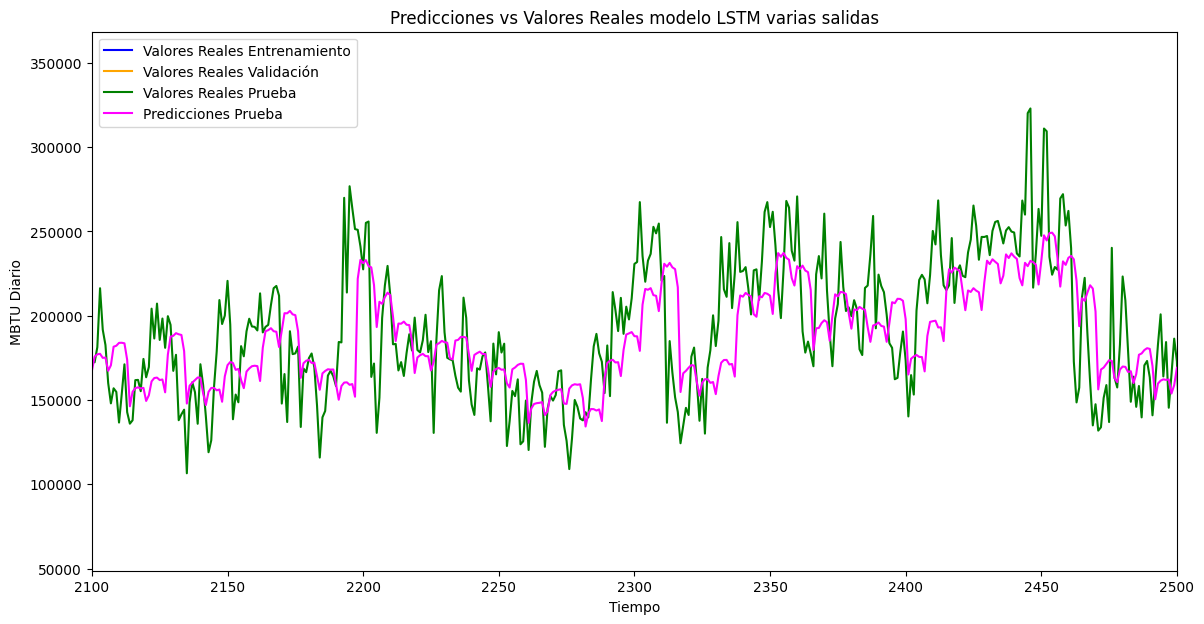

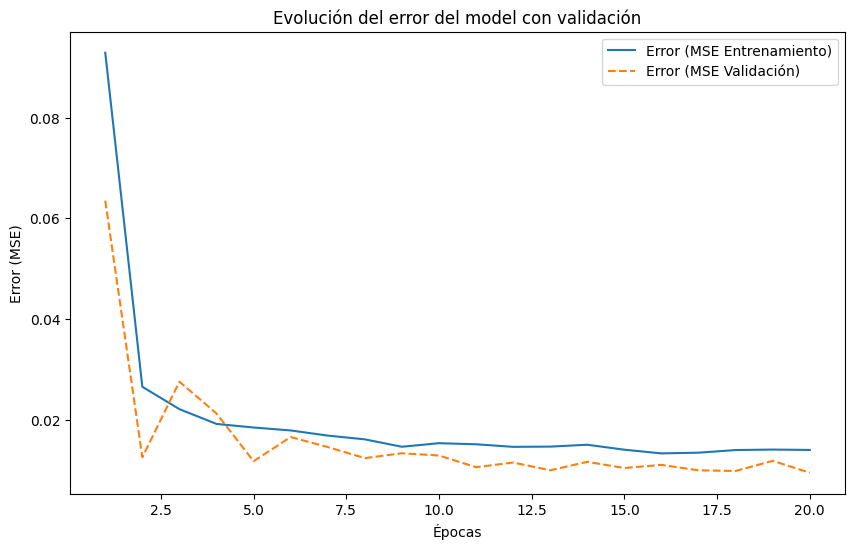

In [159]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    trainPredict_inv_multioutGRU, valPredict_inv_multioutGRU, testPredict_inv_multioutGRU,
                    historia_GRU_multiOut, title='Predicciones vs Valores Reales modelo LSTM varias salidas')

## Pruebas en LSTM y GRU con diferentes predicciones de pasos hacia adelante, con variable exogena

In [160]:
# Separación de datos sin sobrelapamientos.
time_step = 7  # Define el paso de tiempo que usarás en el modelo
output_steps = 7  # Número de pasos a predecir hacia adelante
size = 0.7  # Proporción de datos para el conjunto de entrenamiento
val_size = 0.1  # Proporción de datos para el conjunto de validación

# Establecer semilla
seed_value = 42
tf.random.set_seed(seed_value)  # Para TensorFlow

# Normalizar y dividir los datos
train_LSTM, val_LSTM, test_LSTM, scaler_consumo, scaler_exog = normalize_and_split_LSTM(df_consumos_precios, 'MBTU_daily', 'Precios_diarios', train_size_ratio=size, val_size_ratio=val_size)

#Convertir datos a array
train_LSTM = np.array(train_LSTM)
val_LSTM = np.array(val_LSTM)
test_LSTM = np.array(test_LSTM)

X_train, y_train = create_dataset_multiOut(train_LSTM, output_steps, time_step,  output_steps)
X_val, y_val = create_dataset_multiOut(val_LSTM, output_steps, time_step, output_steps)
X_test, y_test = create_dataset_multiOut(test_LSTM, output_steps, time_step, output_steps)

In [161]:
# Crear el modelo LSTM
model_LSTM_multiOut = Sequential()
model_LSTM_multiOut.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model_LSTM_multiOut.add(Dropout(0.2))
model_LSTM_multiOut.add(LSTM(50, return_sequences=False))
model_LSTM_multiOut.add(Dropout(0.2))
model_LSTM_multiOut.add(Dense(output_steps))  # predicción de múltiples valores

model_LSTM_multiOut.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con validación
historia_LSTM_multiOut = model_LSTM_multiOut.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Hacer predicciones
trainPredict = model_LSTM_multiOut.predict(X_train)
valPredict = model_LSTM_multiOut.predict(X_val)
testPredict = model_LSTM_multiOut.predict(X_test)

# Invertir la normalización para volver a los valores originales
trainPredict_inv_multioutLSTM_exog = scaler_consumo.inverse_transform(trainPredict.flatten().reshape(-1, 1))
valPredict_inv_multioutLSTM_exog = scaler_consumo.inverse_transform(valPredict.flatten().reshape(-1, 1))
testPredict_inv_multioutLSTM_exog = scaler_consumo.inverse_transform(testPredict.flatten().reshape(-1, 1))

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train.flatten().reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.flatten().reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.flatten().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Raíz del Error Cuadrático Medio (RMSE): 33984.66
Error Absoluto Medio (MAE): 25922.44
Error Porcentual Absoluto Medio (MAPE): 14.76%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


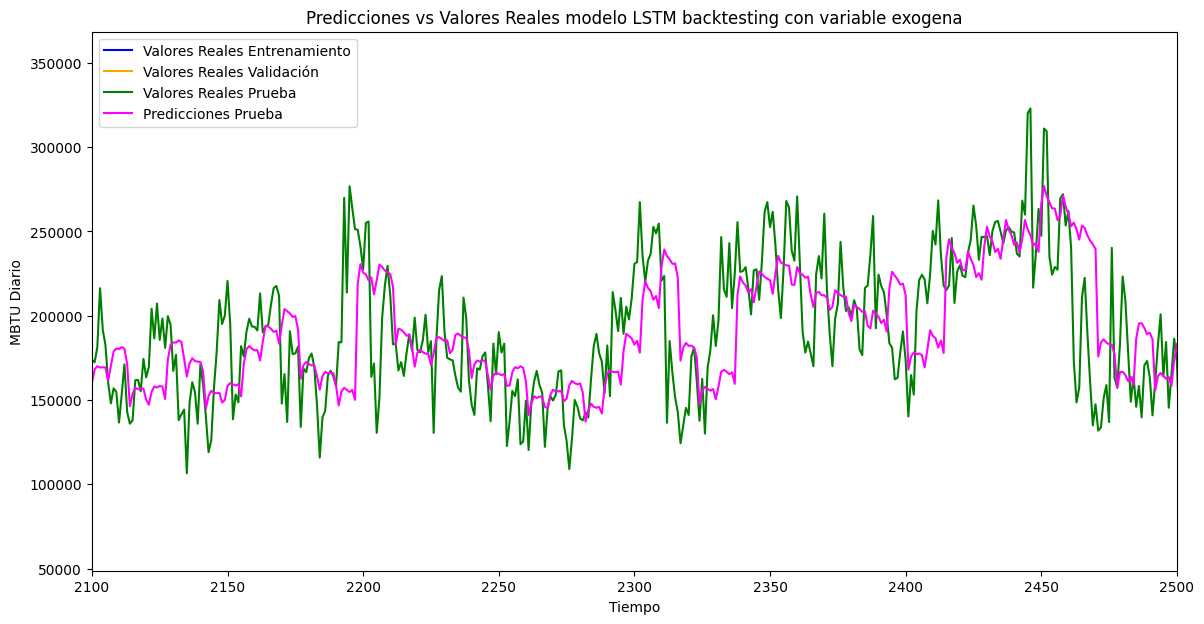

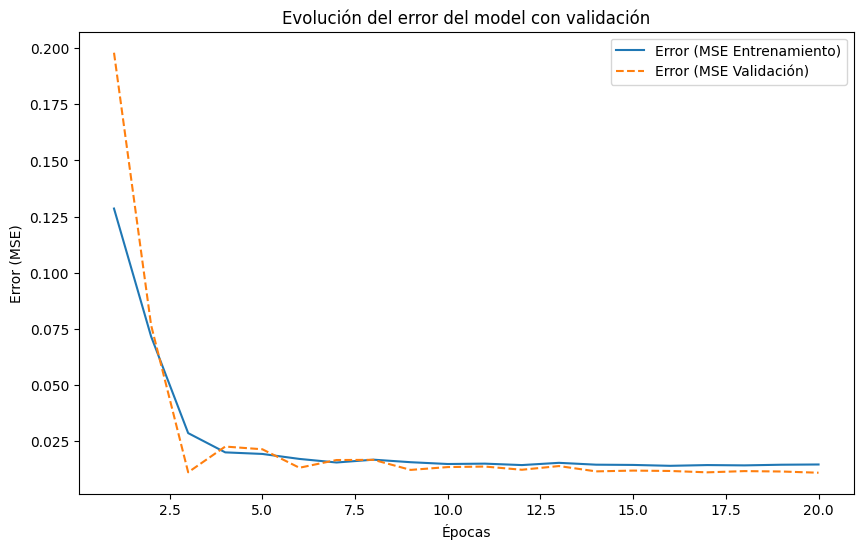

In [162]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    trainPredict_inv_multioutLSTM_exog, valPredict_inv_multioutLSTM_exog, testPredict_inv_multioutLSTM_exog,
                    historia_LSTM_multiOut, title='Predicciones vs Valores Reales modelo LSTM backtesting con variable exogena')

In [163]:
# Construir el modelo GRU
from keras import regularizers
model_GRU_multiOut = Sequential()
model_GRU_multiOut.add(GRU(units=70, return_sequences=True, input_shape=(X_train.shape[1], 2),  bias_regularizer=regularizers.L1L2(1e-3)))
model_GRU_multiOut.add(Dropout(0.2))
model_GRU_multiOut.add(GRU(units=70, return_sequences=False, bias_regularizer=regularizers.L1L2(1e-3)))
model_GRU_multiOut.add(Dropout(0.2))
model_GRU_multiOut.add(Dense(output_steps))  # Predicción de los valores

# Compilar el modelo
model_GRU_multiOut.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_GRU_multiOut = model_GRU_multiOut.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Hacer predicciones
trainPredict = model_GRU_multiOut.predict(X_train)
valPredict = model_GRU_multiOut.predict(X_val)
testPredict = model_GRU_multiOut.predict(X_test)

# Invertir la normalización para volver a los valores originales
trainPredict_inv_multioutGRU_exog = scaler_consumo.inverse_transform(trainPredict.flatten().reshape(-1, 1))
valPredict_inv_multioutGRU_exog = scaler_consumo.inverse_transform(valPredict.flatten().reshape(-1, 1))
testPredict_inv_multioutGRU_exog = scaler_consumo.inverse_transform(testPredict.flatten().reshape(-1, 1))

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train.flatten().reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.flatten().reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.flatten().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Raíz del Error Cuadrático Medio (RMSE): 31289.23
Error Absoluto Medio (MAE): 24201.97
Error Porcentual Absoluto Medio (MAPE): 13.68%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


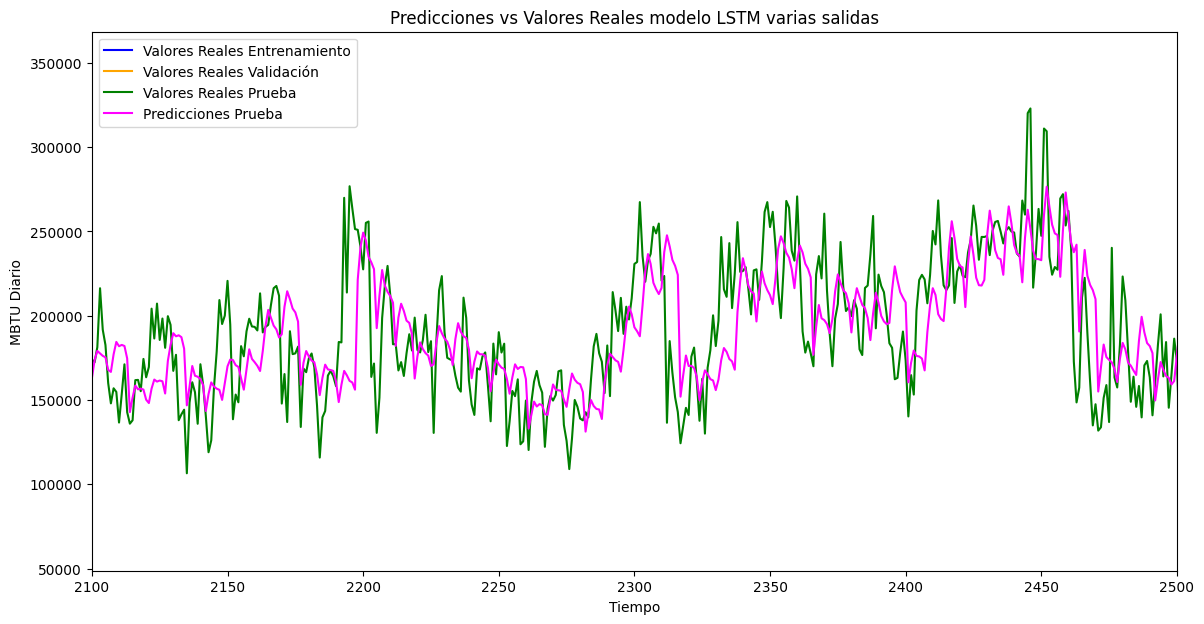

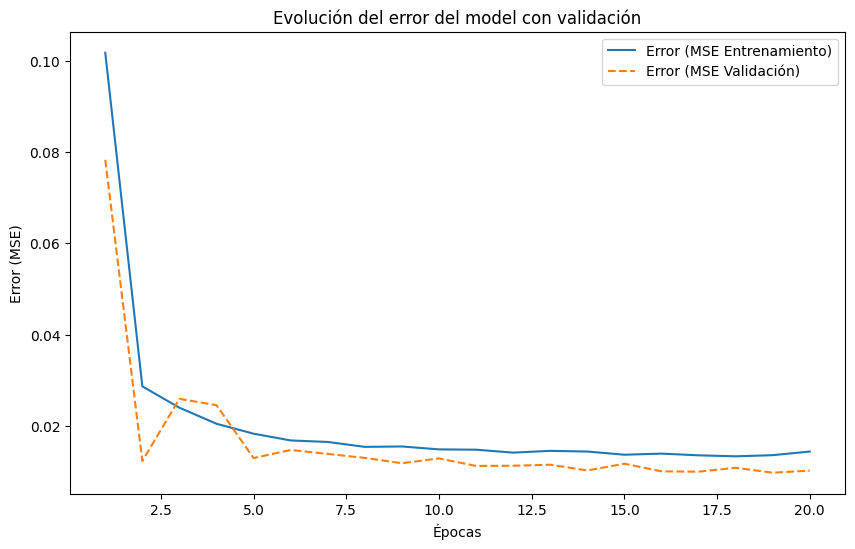

In [164]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    trainPredict_inv_multioutGRU_exog, valPredict_inv_multioutGRU_exog, testPredict_inv_multioutGRU_exog,
                    historia_GRU_multiOut, title='Predicciones vs Valores Reales modelo LSTM varias salidas')

In [165]:
1=0

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (<ipython-input-165-71c6896b3026>, line 1)

### **Pruebas con sobrelapamiento en las ventanas de predicción hacia adelante**

In [ ]:
# Separación de datos sin sobrelapamientos.
time_step = 7  # Define el paso de tiempo que usarás en el modelo
output_steps = 7  # Número de pasos a predecir hacia adelante
size = 0.7  # Proporción de datos para el conjunto de entrenamiento
val_size = 0.15  # Proporción de datos para el conjunto de validación

# Establecer semilla
seed_value = 42
tf.random.set_seed(seed_value)  # Para TensorFlow

# Normalizar y dividir los datos
train_LSTM, val_LSTM, test_LSTM, scaler_consumo, scaler_exog = normalize_and_split_LSTM(df_consumos_precios, 'MBTU_daily', 'Precios_diarios', train_size_ratio=size, val_size_ratio=val_size)

#Convertir datos a array
train_LSTM = np.array(train_LSTM)
val_LSTM = np.array(val_LSTM)
test_LSTM = np.array(test_LSTM)

X_train, y_train = DataPreparationRNN.create_datasetMultipleTimesBackAhead(train_LSTM, n_steps_out = output_steps, n_steps_in = time_step, overlap = output_steps-5)
X_val, y_val = DataPreparationRNN.create_datasetMultipleTimesBackAhead(val_LSTM, n_steps_out = output_steps, n_steps_in = time_step, overlap = output_steps-5)
X_test, y_test = DataPreparationRNN.create_datasetMultipleTimesBackAhead(test_LSTM, n_steps_out = output_steps, n_steps_in = time_step, overlap = output_steps)


In [ ]:
# Crear el modelo LSTM
model_LSTM_multiOut = Sequential()
model_LSTM_multiOut.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_LSTM_multiOut.add(Dropout(0.2))
model_LSTM_multiOut.add(LSTM(50, return_sequences=False))
model_LSTM_multiOut.add(Dropout(0.2))
model_LSTM_multiOut.add(Dense(output_steps))  # predicción de múltiples valores

model_LSTM_multiOut.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con validación
historia_LSTM_ini = model_LSTM_multiOut.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

# Hacer predicciones
trainPredict = model_LSTM_multiOut.predict(X_train.reshape(X_train.shape[0], time_step))
valPredict = model_LSTM_multiOut.predict(X_val.reshape(X_val.shape[0], time_step))
testPredict = model_LSTM_multiOut.predict(X_test.reshape(X_test.shape[0], time_step))

# Invertir la normalización para volver a los valores originales
trainPredict_inv = scaler_consumo.inverse_transform(trainPredict.flatten().reshape(-1, 1))
valPredict_inv = scaler_consumo.inverse_transform(valPredict.flatten().reshape(-1, 1))
testPredict_inv = scaler_consumo.inverse_transform(testPredict.flatten().reshape(-1, 1))

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train.flatten().reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.flatten().reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.flatten().reshape(-1, 1))

In [ ]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    trainPredict_inv, valPredict_inv, testPredict_inv,
                    historia_LSTM_multiOut, title='Predicciones vs Valores Reales modelo LSTM varias salidas')

In [ ]:
# Construir el modelo GRU
from keras import regularizers
model_GRU_multiOut = Sequential()
model_GRU_multiOut.add(GRU(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1),  bias_regularizer=regularizers.L1L2(1e-3)))
model_GRU_multiOut.add(Dropout(0.2))
model_GRU_multiOut.add(GRU(units=70, return_sequences=False, bias_regularizer=regularizers.L1L2(1e-3)))
model_GRU_multiOut.add(Dropout(0.2))
model_GRU_multiOut.add(Dense(output_steps))  # Predicción de los valores

# Compilar el modelo
model_GRU_multiOut.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
historia_GRU_multiOut = model_GRU_multiOut.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

# Hacer predicciones
trainPredict = model_GRU_multiOut.predict(X_train.reshape(X_train.shape[0], time_step))
valPredict = model_GRU_multiOut.predict(X_val.reshape(X_val.shape[0], time_step))
testPredict = model_GRU_multiOut.predict(X_test.reshape(X_test.shape[0], time_step))

# Invertir la normalización para volver a los valores originales
trainPredict_inv = scaler_consumo.inverse_transform(trainPredict.flatten().reshape(-1, 1))
valPredict_inv = scaler_consumo.inverse_transform(valPredict.flatten().reshape(-1, 1))
testPredict_inv = scaler_consumo.inverse_transform(testPredict.flatten().reshape(-1, 1))

# También invertir la normalización de y
y_train_inv = scaler_consumo.inverse_transform(y_train.flatten().reshape(-1, 1))
y_val_inv = scaler_consumo.inverse_transform(y_val.flatten().reshape(-1, 1))
y_test_inv = scaler_consumo.inverse_transform(y_test.flatten().reshape(-1, 1))

In [ ]:
plot_evaluation(y_train_inv, y_val_inv, y_test_inv,
                    trainPredict_inv, valPredict_inv, testPredict_inv,
                    historia_GRU_multiOut, title='Predicciones vs Valores Reales modelo LSTM varias salidas')

# **Pruebas de Backtesting para los modelos implementados**
- En la siguiente sección se realizan pruebas de validación cruzada para series de tiempo de los modelos SARIMAX, LSTM y GRU.
- Las pruebas se implementan acorde para compraciones de modelos.

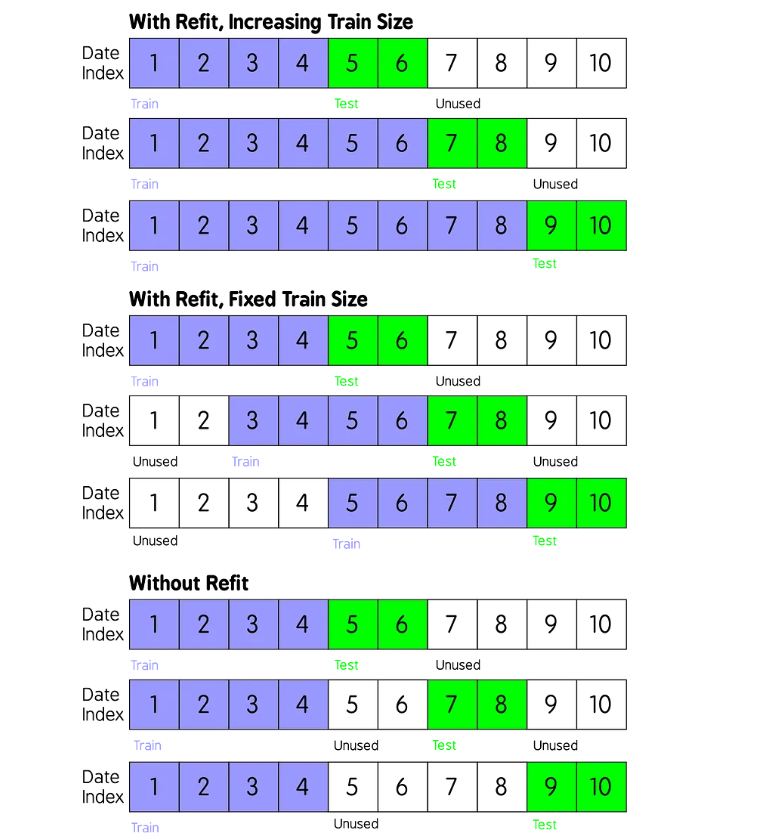

## **BackTesting validación cruzada de los modelos.**

### BackTesting para modelo SARIMAX sin Exogena

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

from skforecast.datasets import fetch_dataset
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 7  # Frecuencia s = 7 para periodos semanales.

# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(p, d, q), seasonal_order=(P, D, Q, s), maxiter=100),
             )
cv_bt = TimeSeriesFold(
        steps              = 7,
        initial_train_size = len(train),
        refit              = False,
        fixed_train_size   = True,
)

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = df_consumos_precios['MBTU_daily'],
                          cv                    = cv_bt,
                          #exog                  = data[['exog_1', 'exog_2']],
                          metric                = 'mean_absolute_percentage_error',
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

In [ ]:
# 1. Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(14, 7))

# Valores reales (se puede usar df_consumos_precios['MBTU_daily'])
plt.plot(df_consumos_precios['MBTU_daily'], label='Valores Reales', color='blue')

# Predicciones (ajusta el índice para que coincida con la serie temporal)
# Get predictions as a 1D array
predictions_1d = predictions['pred'].values

plt.plot(np.arange(len(df_consumos_precios['MBTU_daily']) - len(predictions_1d), len(df_consumos_precios['MBTU_daily'])),
         predictions_1d, label='Predicciones SARIMAX', color='red')

plt.title('Predicciones vs Valores Reales SARIMAX sin variable exogena')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.xlim( len(df_consumos_precios['MBTU_daily'])-len(predictions_1d), len(df_consumos_precios['MBTU_daily']))
plt.legend()
plt.show()

print(f'Error Absoluto Medio (MAE): {metric}')

# y que has guardado las predicciones en 'predictions'
y_real = df_consumos_precios['MBTU_daily'][-len(predictions_1d):].values  # Últimos valores reales
y_pred = predictions_1d # Predicciones de tu modelo

# Calcular RMSE
rmse = np.sqrt(np.mean((y_real - y_pred) ** 2))
# Calcular MAE (ya lo tienes si estás usando la métrica)
mae = mean_absolute_error(y_real, y_pred)
# Calcular MAPE
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')


# 2. Gráfico de la Evolución del Error
# Asumiendo que guardaste los errores en una lista durante el backtesting
# Si no tienes una lista, necesitarás calcularla al hacer el backtesting.
# Por ejemplo, podrías almacenar el MAE en cada paso.

mae_values = []  # Reemplaza con tu lista de errores

# Si no tienes una lista, puedes calcularla aquí:
# Assuming predictions is a DataFrame with a 'pred' column
for i in range(0, len(predictions), 7): # Step by 7 to match backtesting steps
    mae = np.mean(np.abs(predictions['pred'].values[i:i+7] -
                         df_consumos_precios['MBTU_daily'].values[len(train) + i : len(train) + i + 7]))
    mae_values.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Error Absoluto Medio (MAE)', color='orange')
plt.title('Evolución del Error del Modelo SARIMAX')
plt.xlabel('Iteración')
#Limitar eje x

plt.ylabel('Error (MAE)')
plt.legend()
plt.show()


## Backtesting sin refit longitud fija de entrenamiento.

In [ ]:
# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 10  # Frecuencia s = 7 para periodos semanales.


# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(p, d, q), seasonal_order=(P, D, Q, s), maxiter=100),
             )

cv_bt = TimeSeriesFold(
        steps              = 7,
        initial_train_size = len(train),
        refit              = False,
        fixed_train_size   = True,
)

metric_fijo_exog, predictions_fijo_exog = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = df_consumos_precios['MBTU_daily'],
                          cv                    = cv_bt,
                          exog                  = df_consumos_precios['Precios_diarios'],
                          metric                = 'mean_absolute_percentage_error',
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

In [ ]:
# 1. Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(14, 7))

# Valores reales (se puede usar df_consumos_precios['MBTU_daily'])
plt.plot(df_consumos_precios['MBTU_daily'], label='Valores Reales', color='blue')

# Predicciones (ajusta el índice para que coincida con la serie temporal)
# Get predictions as a 1D array
predictions_1d = predictions_fijo_exog['pred'].values

plt.plot(np.arange(len(df_consumos_precios['MBTU_daily']) - len(predictions_1d), len(df_consumos_precios['MBTU_daily'])),
         predictions_1d, label='Predicciones SARIMAX', color='red')

plt.title('Predicciones vs Valores Reales Backtesting SARIMAX con variable exogena')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.legend()
# Fijar limites para el eje x de la grafica
plt.xlim(len(df_consumos_precios['MBTU_daily']) - len(predictions_1d), len(df_consumos_precios['MBTU_daily']))
plt.show()

print(f'Error Absoluto Medio (MAE): {metric_fijo_exog}')

# y que has guardado las predicciones en 'predictions_fijo_solo'
y_real = df_consumos_precios['MBTU_daily'][-len(predictions_1d):].values  # Últimos valores reales
y_pred = predictions_1d # Predicciones de tu modelo

# Calcular RMSE
rmse = np.sqrt(np.mean((y_real - y_pred) ** 2))
# Calcular MAE (ya lo tienes si estás usando la métrica)
mae = mean_absolute_error(y_real, y_pred)
# Calcular MAPE
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')


# 2. Gráfico de la Evolución del Error
# Asumiendo que guardaste los errores en una lista durante el backtesting
# Si no tienes una lista, necesitarás calcularla al hacer el backtesting.
# Por ejemplo, podrías almacenar el MAE en cada paso.

mae_values = []  # Reemplaza con tu lista de errores

# Si no tienes una lista, puedes calcularla aquí:
# Assuming predictions is a DataFrame with a 'pred' column
for i in range(0, len(predictions_fijo_exog), 7): # Step by 7 to match backtesting steps
    mae = np.mean(np.abs(predictions_fijo_exog['pred'].values[i:i+7] -
                         df_consumos_precios['MBTU_daily'].values[len(train) + i : len(train) + i + 7]))
    mae_values.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Error Absoluto Medio (MAE)', color='orange')
plt.title('Evolución del Error del Modelo SARIMAX')
plt.xlabel('Iteración')
plt.ylabel('Error (MAE)')
plt.legend()
plt.show()


In [ ]:
# Definir parámetros (p, d, q) y (P, D, Q, s)
p, d, q = 1, 0, 3  # Estos valores se ajustan según los resultados de ACF/PACF
P, D, Q, s = 1, 1, 1, 7  # Frecuencia s = 7 para periodos semanales.

# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(p, d, q), seasonal_order=(P, D, Q, s), maxiter=100),
             )

metric_fijo, predictions_fijo = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = df_consumos_precios['MBTU_daily'],
                          exog                  = df_consumos_precios['Precios_diarios'],
                          initial_train_size    = len(train),
                          fixed_train_size      = True,
                          steps                 = 7,
                          metric                = 'mean_absolute_error',
                          refit                 = False,
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

In [ ]:
# 1. Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(14, 7))

# Valores reales (se puede usar df_consumos_precios['MBTU_daily'])
plt.plot(df_consumos_precios['MBTU_daily'], label='Valores Reales', color='blue')

# Predicciones (ajusta el índice para que coincida con la serie temporal)
# Get predictions as a 1D array
predictions_1d = predictions_fijo['pred'].values

plt.plot(np.arange(len(df_consumos_precios['MBTU_daily']) - len(predictions_1d), len(df_consumos_precios['MBTU_daily'])),
         predictions_1d, label='Predicciones SARIMAX', color='red')

plt.title('Predicciones vs Valores Reales Backtesting SARIMAX con variable exogena')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.legend()
# Fijar limites para el eje x de la grafica
plt.xlim(2100, 2500)
plt.show()

print(f'Error Absoluto Medio (MAE): {metric_fijo}')

# y que has guardado las predicciones en 'predictions_fijo'
y_real = df_consumos_precios['MBTU_daily'][-len(predictions_1d):].values  # Últimos valores reales
y_pred = predictions_1d # Predicciones de tu modelo

# Calcular RMSE
rmse = np.sqrt(np.mean((y_real - y_pred) ** 2))
# Calcular MAE (ya lo tienes si estás usando la métrica)
mae = mean_absolute_error(y_real, y_pred)
# Calcular MAPE
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')


# 2. Gráfico de la Evolución del Error
# Asumiendo que guardaste los errores en una lista durante el backtesting
# Si no tienes una lista, necesitarás calcularla al hacer el backtesting.
# Por ejemplo, podrías almacenar el MAE en cada paso.

mae_values = []  # Reemplaza con tu lista de errores

# Si no tienes una lista, puedes calcularla aquí:
# Assuming predictions is a DataFrame with a 'pred' column
for i in range(0, len(predictions_fijo), 7): # Step by 7 to match backtesting steps
    mae = np.mean(np.abs(predictions_fijo['pred'].values[i:i+7] -
                         df_consumos_precios['MBTU_daily'].values[len(train) + i : len(train) + i + 7]))
    mae_values.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Error Absoluto Medio (MAE)', color='orange')
plt.title('Evolución del Error del Modelo SARIMAX')
plt.xlabel('Iteración')
plt.ylabel('Error (MAE)')
plt.legend()
plt.show()


### BackTesting para modelo SARIMAX con variable Exogena

In [ ]:
metric_exog, predictions_exog = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = df_consumos_precios['MBTU_daily'],
                          exog                  = df_consumos_precios['Precios_diarios'],
                          initial_train_size    = len(train),
                          fixed_train_size      = False,
                          steps                 = 7,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

In [ ]:
# 1. Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(14, 7))

# Valores reales (se puede usar df_consumos_precios['MBTU_daily'])
plt.plot(df_consumos_precios['MBTU_daily'], label='Valores Reales', color='blue')

# Predicciones (ajusta el índice para que coincida con la serie temporal)
# Get predictions as a 1D array
predictions_1d = predictions_exog['pred'].values

plt.plot(np.arange(len(df_consumos_precios['MBTU_daily']) - len(predictions_1d), len(df_consumos_precios['MBTU_daily'])),
         predictions_1d, label='Predicciones SARIMAX', color='red')

plt.title('Predicciones vs Valores Reales Backtesting SARIMAX con variable exogena')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.legend()
plt.show()

print(f'Error Absoluto Medio (MAE): {metric_exog}')

# y que has guardado las predicciones en 'predictions_exog'
y_real = df_consumos_precios['MBTU_daily'][-len(predictions_1d):].values  # Últimos valores reales
y_pred = predictions_1d # Predicciones de tu modelo

# Calcular RMSE
rmse = np.sqrt(np.mean((y_real - y_pred) ** 2))
# Calcular MAE (ya lo tienes si estás usando la métrica)
mae = mean_absolute_error(y_real, y_pred)
# Calcular MAPE
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')


# 2. Gráfico de la Evolución del Error
# Asumiendo que guardaste los errores en una lista durante el backtesting
# Si no tienes una lista, necesitarás calcularla al hacer el backtesting.
# Por ejemplo, podrías almacenar el MAE en cada paso.

mae_values = []  # Reemplaza con tu lista de errores

# Si no tienes una lista, puedes calcularla aquí:
# Assuming predictions is a DataFrame with a 'pred' column
for i in range(0, len(predictions_exog), 7): # Step by 7 to match backtesting steps
    mae = np.mean(np.abs(predictions_exog['pred'].values[i:i+7] -
                         df_consumos_precios['MBTU_daily'].values[len(train) + i : len(train) + i + 7]))
    mae_values.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Error Absoluto Medio (MAE)', color='orange')
plt.title('Evolución del Error del Modelo SARIMAX')
plt.xlabel('Iteración')
plt.ylabel('Error (MAE)')
plt.legend()
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_consumos_precios['MBTU_daily'], lags=20)
plt.show()

In [ ]:
def backtesting_with_refit_increasing_train(model, X_train_data, X_test_data, y_train_data, y_test_data, time_step):
    predictions = []
    MAPE = []
    # actuals = []

    model.fit(X_train_data, y_train_data, epochs=15, verbose=1, batch_size=32)  # Ajusta los epochs y verbose según sea necesario
    X_input = X_test_data[0:time_step]
    # Hacer la predicción
    pred1 = model.predict(X_input)
    mape1 = np.mean(np.abs((pred1.flatten() - y_test[0:time_step].flatten()) / y_test[0:time_step].flatten())) * 100
    # Guardar la predicción y el valor real
    predictions.append(pred1[0, 0])
    MAPE.append(mape1)

    # Bucle de backtesting
    for i in range(0, len(X_test_data), time_step):
        # Crear ventanas de entrenamiento que comienzan desde el principio
        X_train = []
        y_train = []

        # Recorrer desde el inicio hasta el índice actual para aumentar el conjunto de entrenamiento
        if i + 2*time_step <= len(X_test_data):
            X_train = np.concatenate((X_train_data, X_test_data[0:i + time_step]), axis=0)
            y_train = np.concatenate((y_train_data, y_test_data[0:i + time_step]), axis=0)
            print(X_train.shape)
            print(y_train.shape)
            # Obtener la ventana de prueba para predecir
            X_input = X_test_data[i + time_step:i + 2*time_step]
            # Reajustar el modelo con el conjunto de entrenamiento actualizado
            model.fit(X_train, y_train, epochs=15, verbose=0, batch_size=32)  # Ajusta los epochs y verbose según sea necesario
            # Hacer la predicción
            pred = model.predict(X_input)
            mape = np.mean(np.abs((pred.flatten() - y_test[i + time_step:i + 2*time_step].flatten()) / y_test[i + time_step:i + 2*time_step].flatten())) * 100
            # Guardar la predicción y el valor real
            predictions.extend(pred.flatten())
            MAPE.append(mape)
        # else:
        #     X_train = np.append(X_train_data, X_test_data[0:len(X_test_data)]).reshape(X_train_data.shape[0]+(i+time_step), X_train_data.shape[1])
        #     y_train = np.append(y_train_data, y_test_data[0:len(X_test_data)])
        #     # Obtener la ventana de prueba para predecir
        #     X_input = X_test_data[i:]
        #actuals.append(data[i + time_step])

    return np.array(predictions), np.array(MAPE) #, np.array(actuals)



In [ ]:
# Separación de datos
time_step = 7  # Define el paso de tiempo que usarás en el modelo
output_steps = 1  # Número de pasos a predecir hacia adelante
size = 0.7  # Proporción de datos para el conjunto de entrenamiento
val_size = 0.15  # Proporción de datos para el conjunto de validación

# Establecer semilla
seed_value = 42
tf.random.set_seed(seed_value)  # Para TensorFlow

# Normalizar y dividir los datos
train_LSTM, val_LSTM, test_LSTM, scaler_consumo, scaler_exog = normalize_and_split_LSTM(df_consumos_precios, 'MBTU_daily', 'Precios_diarios', train_size_ratio=size, val_size_ratio=val_size)

# Crear los datasets para el modelo
X_train, y_train, X_val, y_val, X_test, y_test = create_datasets(train_LSTM, val_LSTM, test_LSTM, time_step, output_steps)

# Seleccionar la primera columna de la última dimensión, no incluir la variable exógena.
X_train_mbtu = X_train[:, :, 0]
X_val_mbtu = X_val[:, :, 0]
X_test_mbtu = X_test[:, :, 0]

In [ ]:
# Unir los datos de entrenamiento y validación
X_train_back = np.concatenate((X_train_mbtu, X_val_mbtu), axis=0)
y_train_back = np.concatenate((y_train, y_val), axis=0)

predictions, MAPE = backtesting_with_refit_increasing_train(model_LSTM_ini, X_train_back, X_test_mbtu, y_train_back, y_test, time_step)

In [ ]:
# Invertir los valores
# Invertir la normalización
test_predict = scaler_consumo.inverse_transform(predictions.reshape(-1, 1))  # Invertir la normalización

# Obtener los valores reales
y_test_inv = scaler_consumo.inverse_transform(y_test.reshape(-1, 1))


# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv[time_step:], label='Valores Reales', color='blue')
plt.plot(test_predict, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('MBTU Diario')
plt.legend()
plt.show()


# Evaluar el error
# Calcular métricas de evaluación
rmse = np.sqrt(np.mean((test_predict.flatten() - y_test_inv[time_step:-5].flatten()) ** 2))
mae = np.mean(np.abs(test_predict.flatten() - y_test_inv[time_step:-5].flatten()))
mape = np.mean(np.abs((test_predict.flatten() - y_test_inv[time_step:-5].flatten()) / y_test_inv[time_step:-5].flatten())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

# Visualizar la evolución del MAPE
plt.figure(figsize=(14, 7))
plt.plot(MAPE, label='MAPE', color='blue')
plt.title('Evolución de los errores en backtesting')
plt.xlabel('Cantidad de iteraciones')
plt.ylabel('% porcentaje de error')
plt.legend()
plt.show()

# Opcional: Gráfico del error
errors = np.array(y_test_inv[time_step:-5] - test_predict)
plt.figure(figsize=(14, 7))
plt.plot(errors, label='Error (Valores Reales - Predicciones)', color='red')
plt.axhline(0, color='black', lw=1, ls='--')
plt.title('Comportamiento del Error')
plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.legend()
plt.show()
